<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos 

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*. 

In [3]:
pip install numpy==1.26.4

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [6]:
import session_info

session_info.show(html=False)

-----
matplotlib          3.8.4
numpy               1.26.4
pandas              2.0.3
seaborn             0.13.2
session_info        1.0.0
sklearn             1.4.0
-----
IPython             8.14.0
jupyter_client      8.3.0
jupyter_core        5.3.1
-----
Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22621-SP0
-----
Session information updated at 2024-09-01 23:06


Esta es la session info necesaria para correr los datos:

### Session Information

| Package         | Version                                           |
|-----------------|---------------------------------------------------|
| matplotlib      | 3.8.4                                             |
| numpy           | 1.26.3                                            |
| pandas          | 2.0.3                                             |
| seaborn         | 0.13.2                                            |
| session_info    | 1.0.0                                             |
| IPython         | 8.14.0                                            |
| jupyter_client  | 8.3.0                                             |
| jupyter_core    | 5.3.1                                             |

| Python Version  | Info                                              |
|-----------------|---------------------------------------------------|
| Python          | 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)] |


Matplotlib y Seaborn deben estar en esa version para que corra


In [7]:
df_datos = pd.read_csv("./data/datos_clientes.csv")
df_datos.head()

Id_Cliente  Genero  Edad   Ingreso  Puntaje_Gasto
0           1   Mujer    41  98115.05             39
1           2   Mujer    20  35458.14             75
2           3   Mujer    68  59872.08             55
3           4  Hombre    63  48508.93             51
4           5   Mujer    31  44431.11             54

Se cargan los datos en el notebook

### 2. Análisis preliminar. 

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

In [8]:
# Utilice este espacio para escribir el código.
n,v = df_datos.shape
print("cantidad de datos: {n}, cantidad de vairables: {v}".format(n=n,v=v))

cantidad de datos: 200, cantidad de vairables: 5


In [9]:
#reporte de datos nulos
df_datos.isna().sum()

Id_Cliente       0
Genero           0
Edad             0
Ingreso          0
Puntaje_Gasto    0
dtype: int64

El dataset no tiene valores nulos y cuenta con 5 variables las cuales se listan a continuacion :
Variables Numericas
* **Id_Cliente**: identificador unico del cliente
* **Edad**: edad del cliente en años
* **Ingreso**: Ingresos anuales del cliente
* **Puntaje_Gasto**: variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.
Variables Categoricas
* **Genero**: valor binario entre (Mujer, Hombre)

In [10]:
df_datos.describe()

Id_Cliente        Edad        Ingreso  Puntaje_Gasto
count  200.000000  200.000000     200.000000     200.000000
mean   100.500000   38.850000   60624.446600      50.200000
std     57.879185   13.969007   26262.903416      25.823522
min      1.000000   18.000000   13458.020000       1.000000
25%     50.750000   28.750000   41512.787500      34.750000
50%    100.500000   36.000000   60777.960000      50.000000
75%    150.250000   49.000000   77143.865000      73.000000
max    200.000000   70.000000  138584.520000      99.000000

In [11]:
def rangos_etarios(row):
    edad = row
    if edad < 18:
        return '0. -18'
    elif edad <= 24:
        return '1. 18-24'
    elif edad <= 34:
        return '2. 25-34'
    elif edad <= 44:
        return '3. 35-44'
    elif edad <= 54:
        return '4. 45-54'
    elif edad <= 64:
        return '5. 55-64'
    elif edad >= 65:
        return '6. 65+'
    

# Aplicar la función a la columna 'Fecha de Llegada'
df_datos['rango_edades'] = df_datos['Edad'].apply(rangos_etarios)

#### Descripctiva variables generales
A continuacion la descripcion de cada variable de forma independiente

In [12]:
def describe_variables(df,variable,grupo=None):

    
    if grupo is None:
        col = variable
        display(df[[col]].describe().T)
        
        n_cols = 3
        n_rows = 1

        fig,ax =plt.subplots(n_rows,n_cols,figsize=(n_cols*8,n_rows*5))
        axs = ax.flatten()

        sns.histplot(data=df, x=col, color="seagreen",ax=axs[0])
        axs[0].set_title("Histograma de la variable: {}".format(col))

        sns.boxplot(data=df, x=col, color="seagreen",ax=axs[1])
        axs[1].set_title("Boxplot de la variable {}".format(col))

        sns.violinplot(data=df.sort_values(by=col), x=variable,ax=axs[2], inner="quart", color="seagreen")
        sns.swarmplot(data=df.sort_values(by=col), x=variable,ax=axs[2], color="white")
        axs[2].set_title("Dispersion de la variable {}".format(col))

        plt.show()
    
    else:
    
    
        col = grupo
        
        display(df.groupby(col)[[variable]].describe())

        vars = np.sort(df_datos[col].unique())

        n_cols = 2
        n_rows = int(np.ceil((len(vars)+ 2)/n_cols)) 

        fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*15,n_rows*6.5))
        axs = ax.flatten()

        for i,v in enumerate(vars):
            
            fltr = df[col] == v
            sns.histplot(data=df[fltr],x=variable, color="seagreen",ax=axs[i])
            axs[i].set_title("distribucion de variable {c} para los categoria: {i}".format(c=col, i = v))


        sns.boxplot(data=df.sort_values(by=col), x=variable, hue=col,ax=axs[i+1], y=col, legend=True)
        axs[i+1].set_title("Boxplot de la variable {}".format(col))
        sns.violinplot(data=df.sort_values(by=col), x=variable,ax=axs[i+2], y=col,hue=col, inner="quart")
        sns.swarmplot(data=df.sort_values(by=col), x=variable,ax=axs[i+2], y=col, color="white")
        axs[i+2].set_title("Dispersion de la variable {} por categorias".format(col))

    plt.show()

# def describe_variables_categ(df,col,grupo=None):

#     if grupo is None:
#         gr = df.groupby(col).count()[["Id_Cliente"]]
#         gr["pct"] = np.round(100*gr/gr.sum(),2)
#         gr = gr.reset_index()
#         display(gr)

#         order = gr[col].tolist()

#         fig,ax =plt.subplots(1,1,figsize=(8,5))
#         sns.barplot(data=df, x=col, y="Id_Cliente", color="seagreen",ax=ax , order=order,errorbar=None)
#         ax.set_title("Grafica de Barras de la variable: {}".format(col))

#         plt.show()
#     else:
#         gr = df.groupby([col,grupo]).count()[["Id_Cliente"]].reset_index()
#         display(gr)

#         order = gr[col].unique()
        
#         fig,ax =plt.subplots(1,1,figsize=(8,5))
#         sns.barplot(data=df.sort_values(by=col), x=col, y="Id_Cliente", color="seagreen",ax=ax, hue=grupo, order=order, errorbar=None)
#         ax.set_title("Grafica de Barras de la variable {a}, agrupada por {b}".format(a=col, b = grupo))

#         plt.show()

In [13]:
def describe_variables_categ(df, col, grupo=None):
    if grupo is None:
        # Contar el número de ocurrencias por categoría
        gr = df.groupby(col).size().reset_index(name='count')
        gr['pct'] = np.round(100 * gr['count'] / gr['count'].sum(), 2)
        gr = gr.sort_values(by='count', ascending=False)  # Ordenar por conteo
        
        # Mostrar los datos en el orden correcto
        display(gr)

        # Crear el gráfico de barras
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        sns.barplot(data=gr, x=col, y='count', color='seagreen', ax=ax, order=gr[col], errorbar=None)
        ax.set_title(f"Gráfica de Barras de la variable: {col}")
        plt.show()
    else:
        # Contar el número de ocurrencias por categoría y grupo
        gr = df.groupby([col, grupo]).size().reset_index(name='count')
        gr = gr.sort_values(by='count', ascending=False)  # Ordenar por conteo

        # Mostrar los datos en el orden correcto
        display(gr)
        
        # Crear el gráfico de barras
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        sns.barplot(data=gr, x=col, y='count', hue=grupo, color='seagreen', ax=ax, order=gr[col].unique(), errorbar=None)
        ax.set_title(f"Gráfica de Barras de la variable {col}, agrupada por {grupo}")
        plt.show()

count   mean        std   min    25%   50%   75%   max
Edad  200.0  38.85  13.969007  18.0  28.75  36.0  49.0  70.0

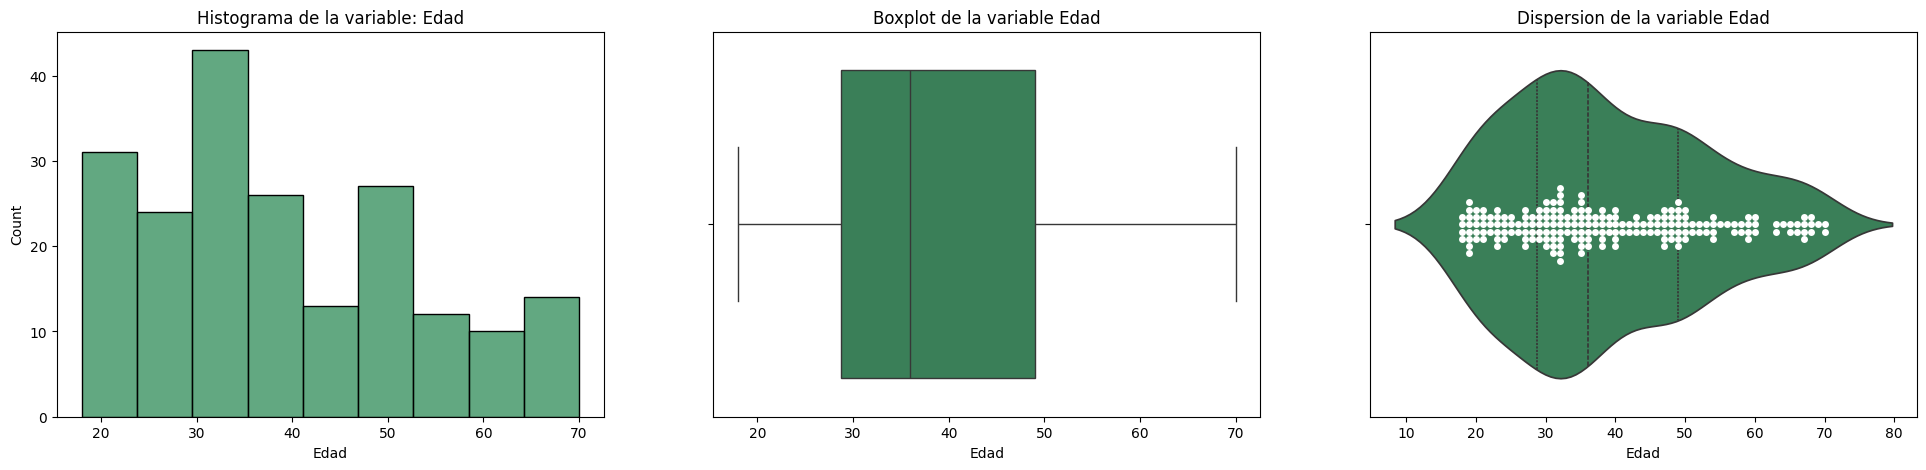

In [14]:
describe_variables(df_datos,variable="Edad")

Se tienen en este caso 200 datos de la variable edad con 38.5 años de media pasando de 18 años a 70 años

rango_edades  count   pct
1     2. 25-34     54  27.0
2     3. 35-44     42  21.0
3     4. 45-54     39  19.5
0     1. 18-24     35  17.5
4     5. 55-64     16   8.0
5       6. 65+     14   7.0

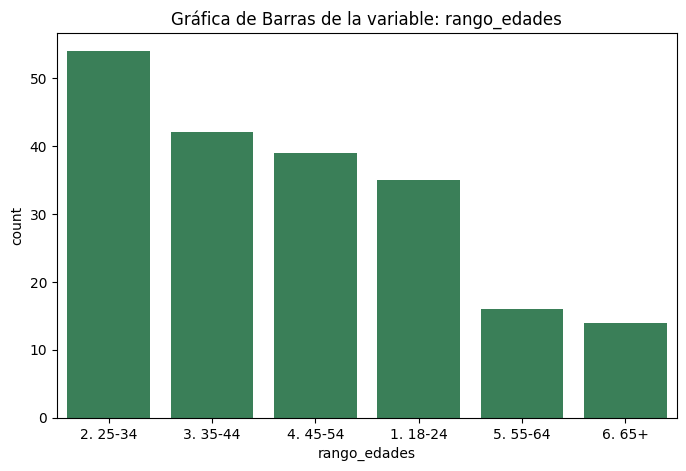

In [15]:
describe_variables_categ(df_datos, col="rango_edades")

Se puede ver como se ven los rangos de edades donde estan distribuidos de manera bastante equitativa

count        mean           std       min         25%       50%  \
Ingreso  200.0  60624.4466  26262.903416  13458.02  41512.7875  60777.96   

               75%        max  
Ingreso  77143.865  138584.52

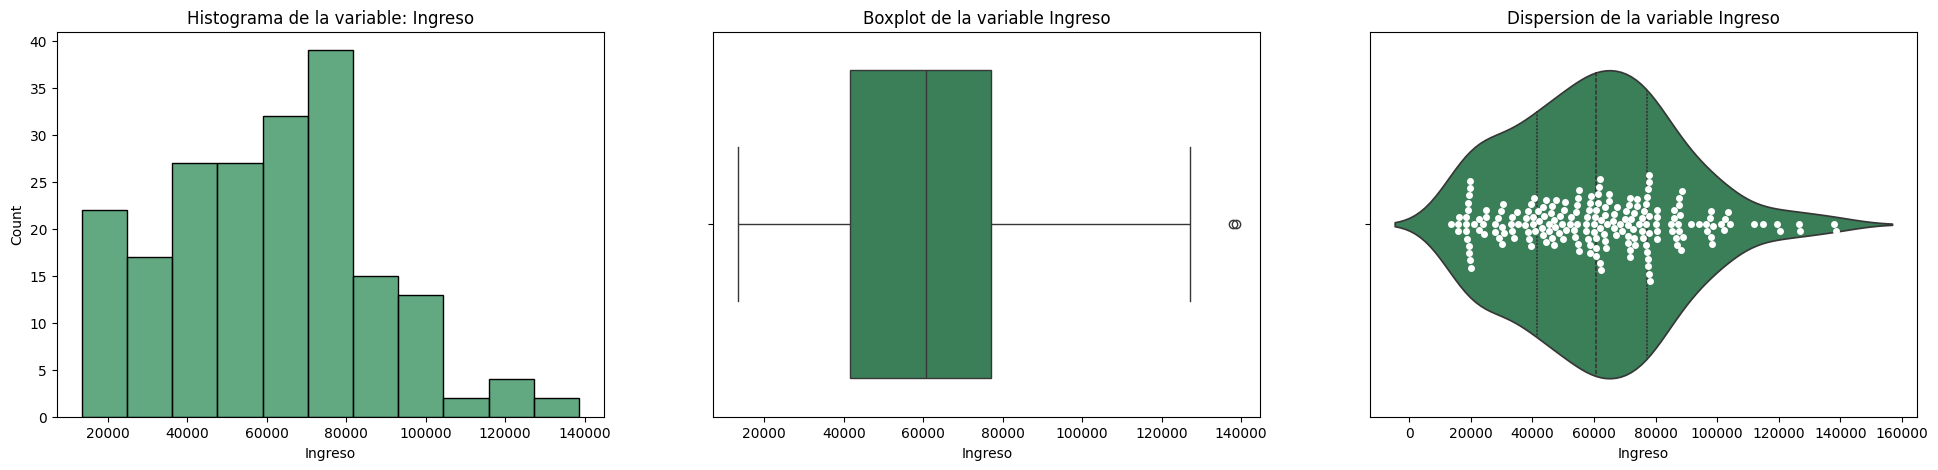

In [16]:
describe_variables(df_datos,variable="Ingreso")

Se ve entonces la distriibucion de la variable ingreso donde la media de ingreso es 60624.4 y como se ven algunos outliers

count  mean        std  min    25%   50%   75%   max
Puntaje_Gasto  200.0  50.2  25.823522  1.0  34.75  50.0  73.0  99.0

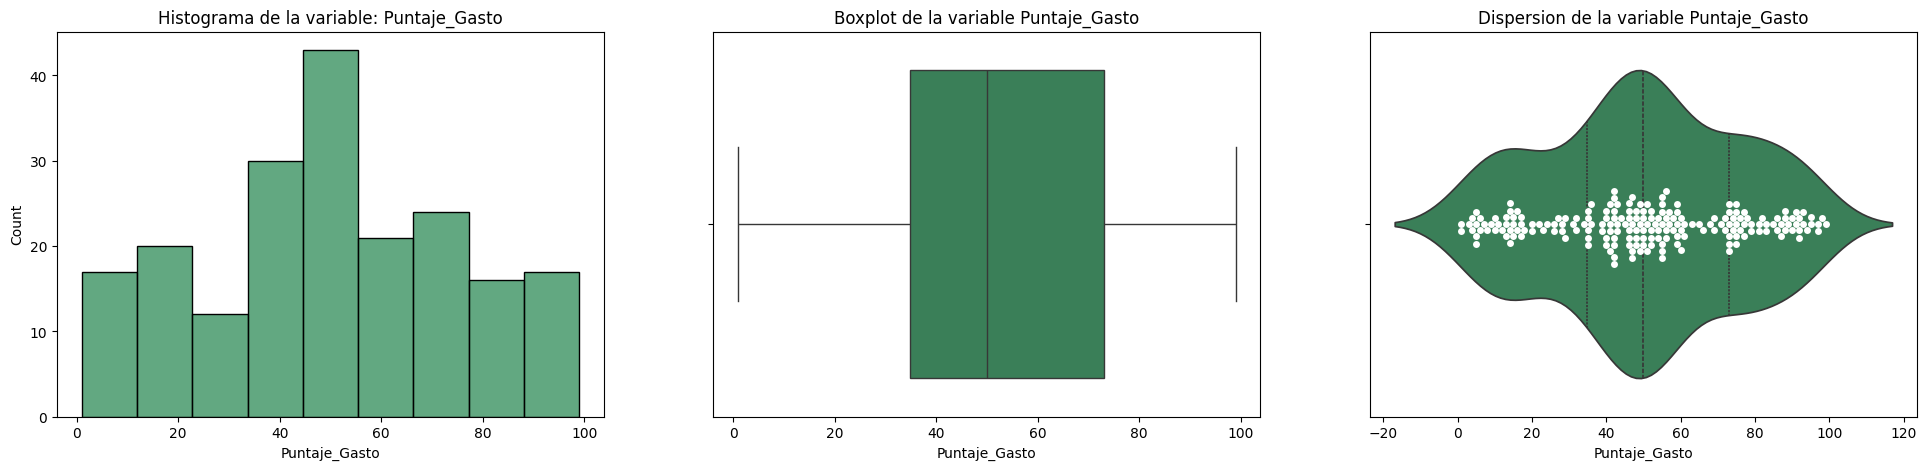

In [17]:
describe_variables(df_datos,variable="Puntaje_Gasto")

Tambien vemos la variable de puntaje gasto, recordemos que es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto. Por lo que vemos la media es de 50.2

Genero  count   pct
1   Mujer    112  56.0
0  Hombre     88  44.0

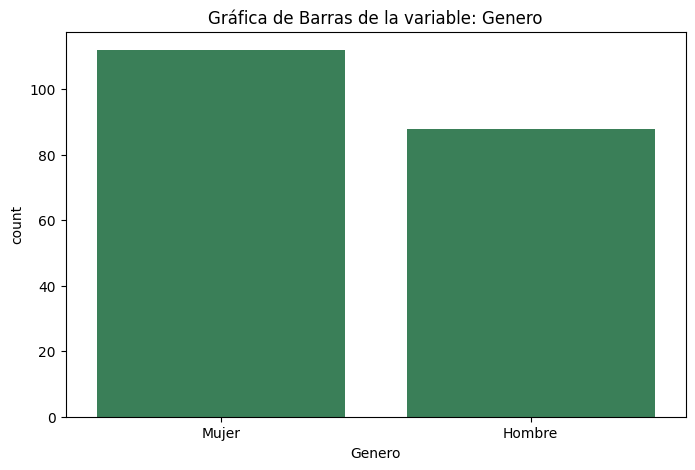

In [18]:
describe_variables_categ(df_datos, col="Genero")

In [19]:
df_datos["Genero"].value_counts()

Genero
Mujer     112
Hombre     88
Name: count, dtype: int64

Se puede ver que hay mas mujeres que hombres, 56% son mujeres en los datos y 44% hombres

#### Relacion entre variables

Ingreso                                                               \
         count          mean           std       min         25%        50%   
Genero                                                                        
Hombre    88.0  62126.660455  26765.492953  13458.02  45003.0800  61706.565   
Mujer    112.0  59444.135714  25920.459216  15766.84  40013.4125  59355.305   

                               
               75%        max  
Genero                         
Hombre  77731.3025  138584.52  
Mujer   76788.3875  126685.78

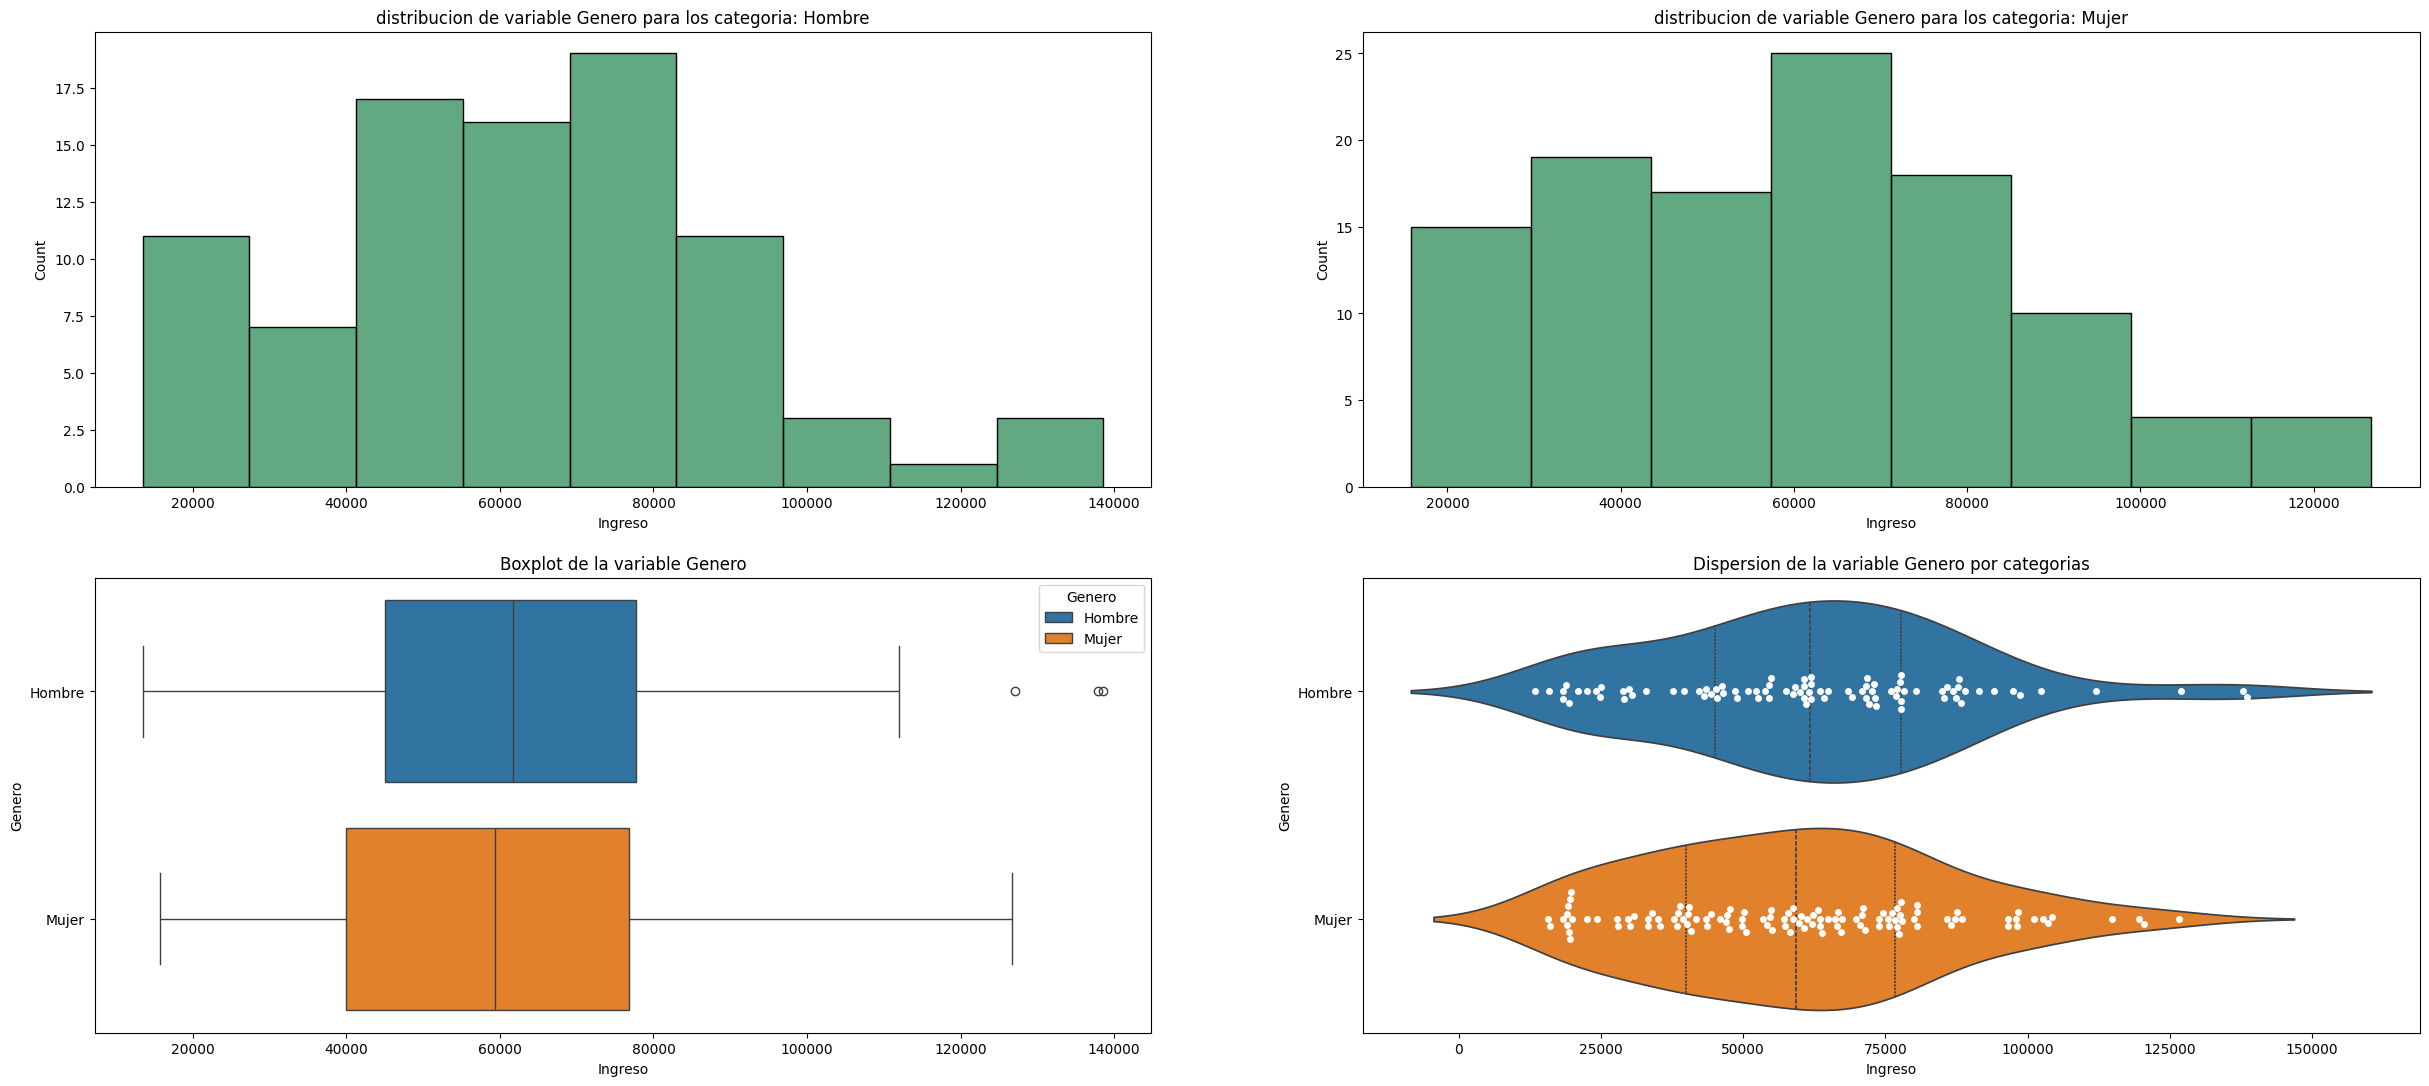

In [20]:
describe_variables(df_datos,"Ingreso",grupo="Genero")

Vemos entonces la distribucion de genero y sus ingresos, se ve entonces que el ingreso promedio para los hombres es mas alto, y tiene unos outliers que llegan a ingresos mucho mas altos


Ingreso                                                    \
               count          mean           std       min         25%   
rango_edades                                                             
1. 18-24        35.0  44454.795429  20378.208373  13458.02  24465.3200   
2. 25-34        54.0  71157.328148  27885.788157  19003.52  50141.6575   
3. 35-44        42.0  66957.096905  27722.049259  18797.16  50771.2225   
4. 45-54        39.0  58786.491026  24276.268114  24402.32  42447.5600   
5. 55-64        16.0  56357.093125  22351.828240  18434.74  46947.2075   
6. 65+          14.0  51420.789286  12686.437083  18437.21  45659.1800   

                                                
                    50%         75%        max  
rango_edades                                    
1. 18-24      46455.340  61564.3550   80360.65  
2. 25-34      75824.910  85872.9375  138584.52  
3. 35-44      71638.860  86762.7750  119534.68  
4. 45-54      55041.390  67337.0950  126685.78  
5. 55-64      54718.180  72384.2775   94049.49  
6. 65+        51546.645  61858.4675   64156.37

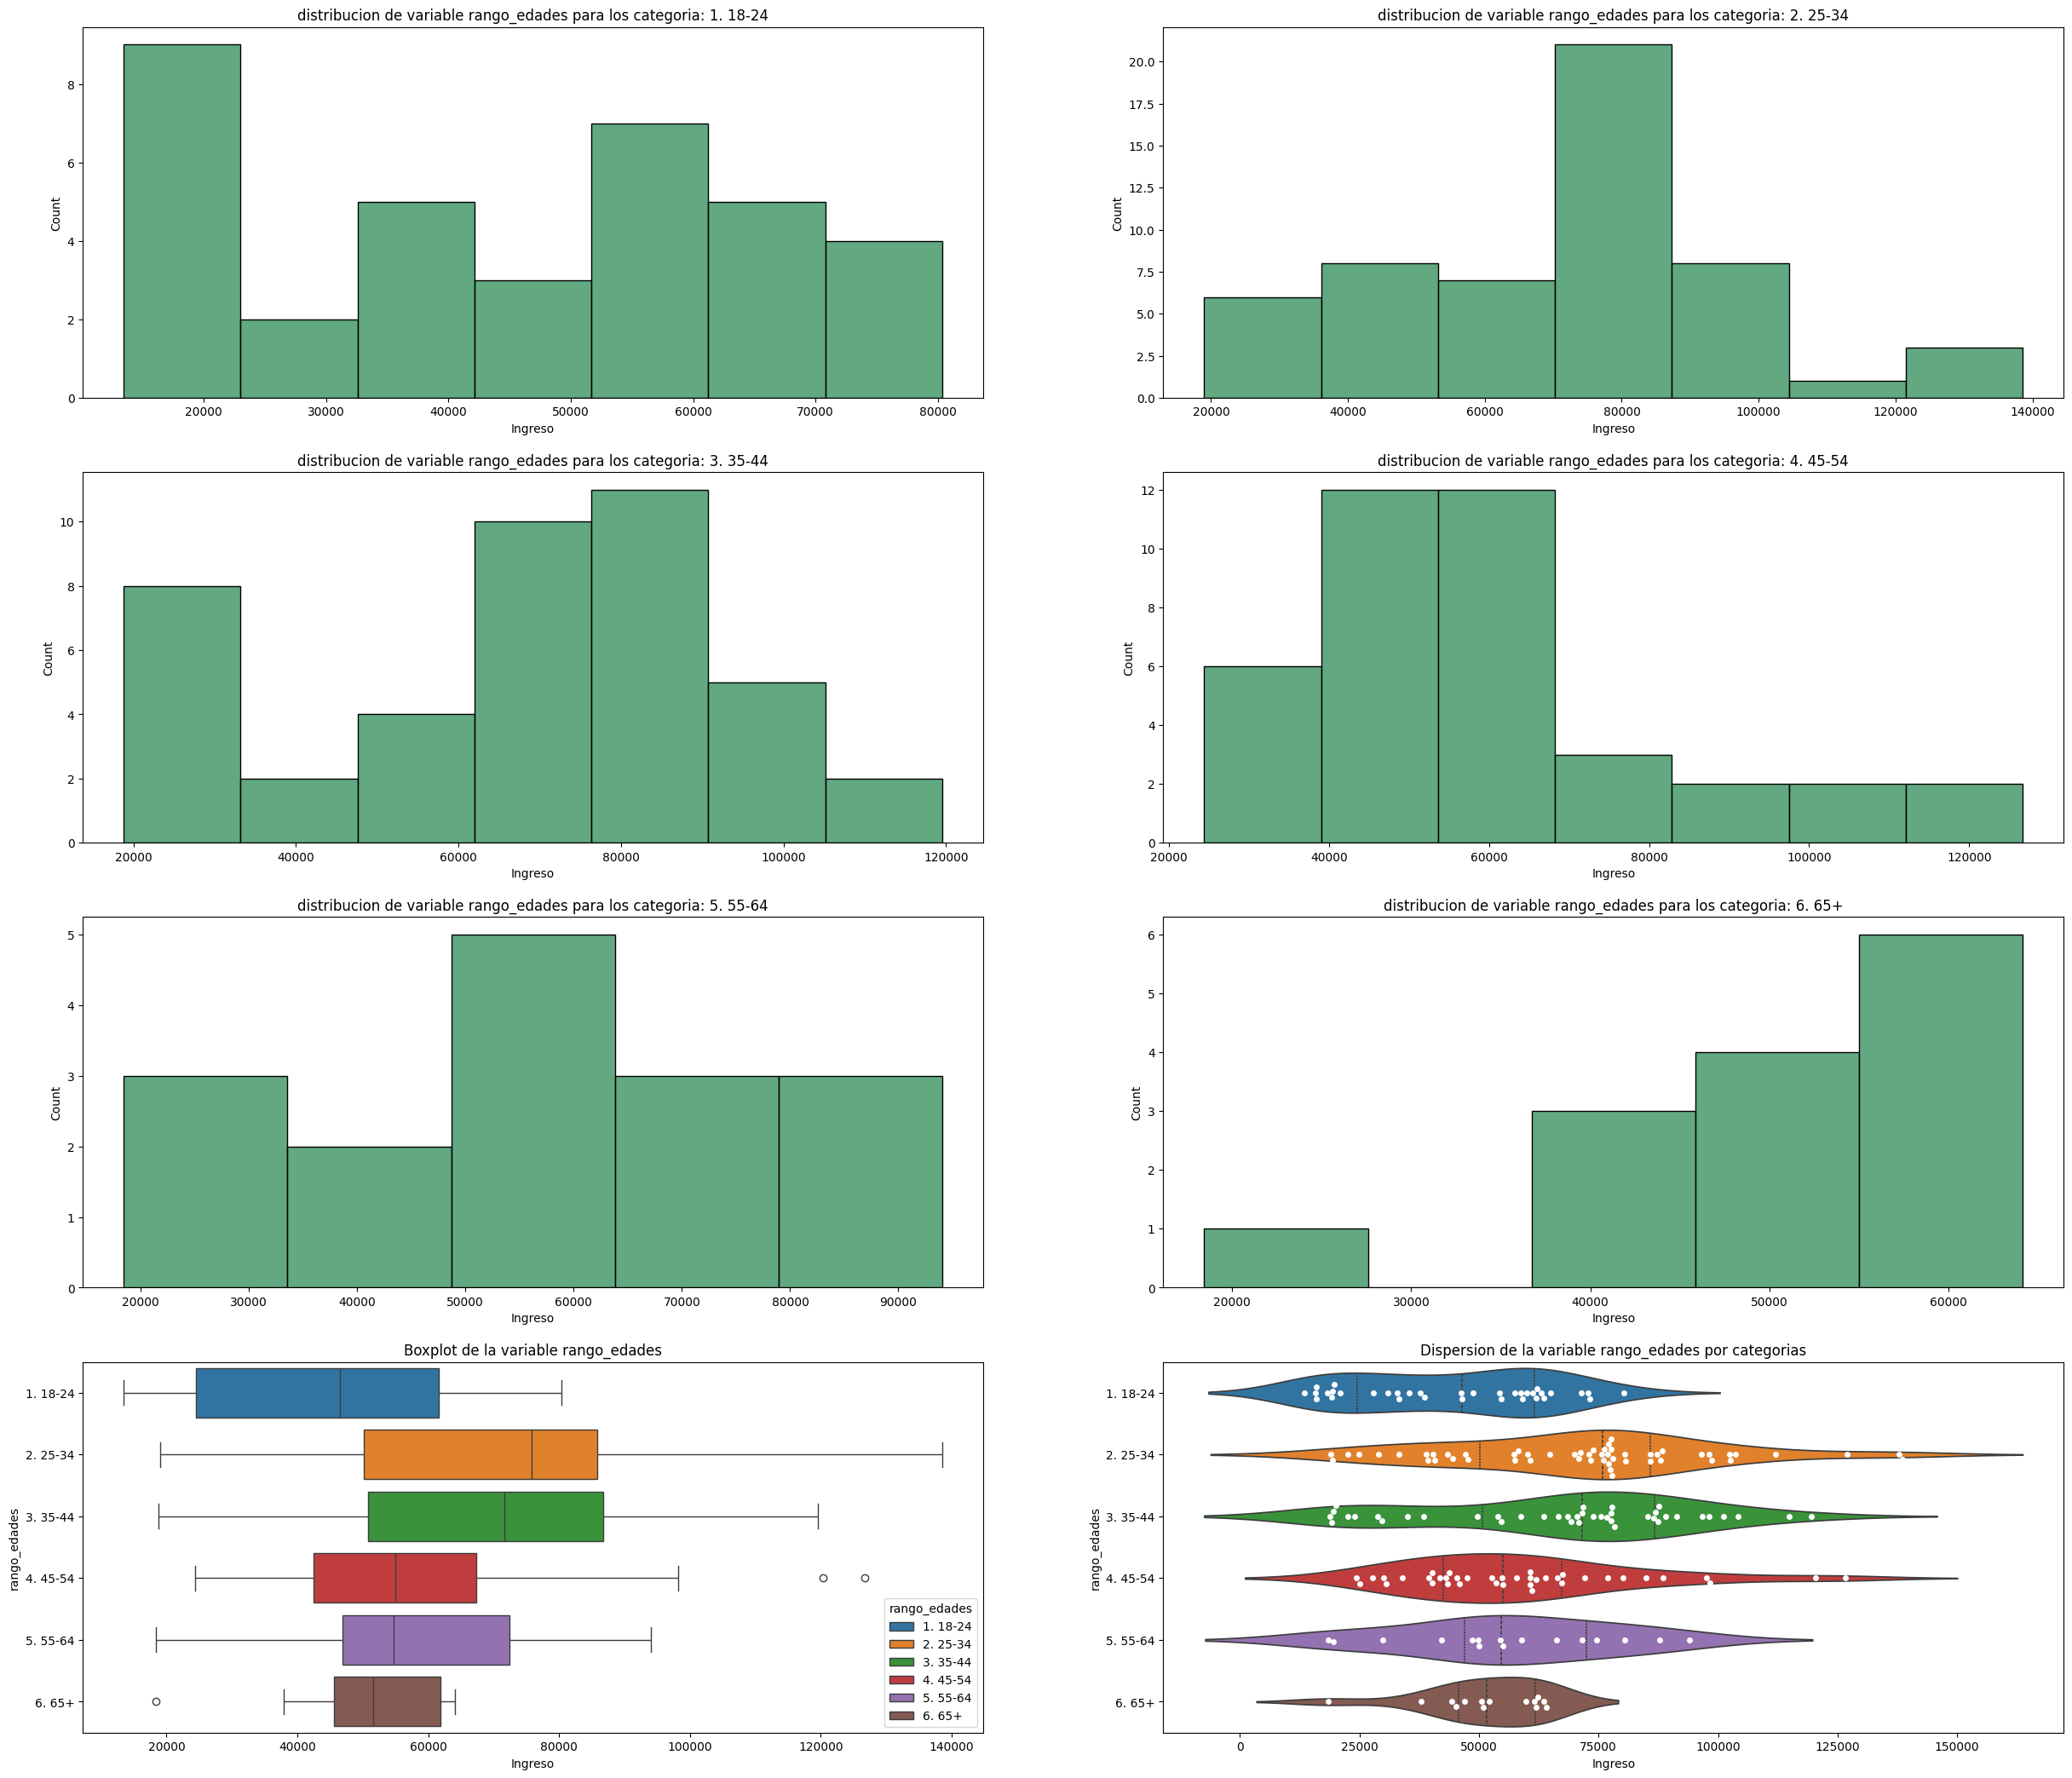

In [21]:
describe_variables(df_datos,"Ingreso",grupo="rango_edades")

Tambien vemos la distribucion de ingresos por rangos de edad. Vemos que ell rango de edad con mayores ingresos promedi es 25-34, asi como tambien los outliers con ingresos mas altos. El rango de edad con media mas baja es 18-24. 

Puntaje_Gasto                                                  
               count       mean       std  min   25%   50%   75%   max
Genero                                                                
Hombre          88.0  48.511364  27.89677  1.0  24.5  50.0  70.0  97.0
Mujer          112.0  51.526786  24.11495  5.0  35.0  50.0  73.0  99.0

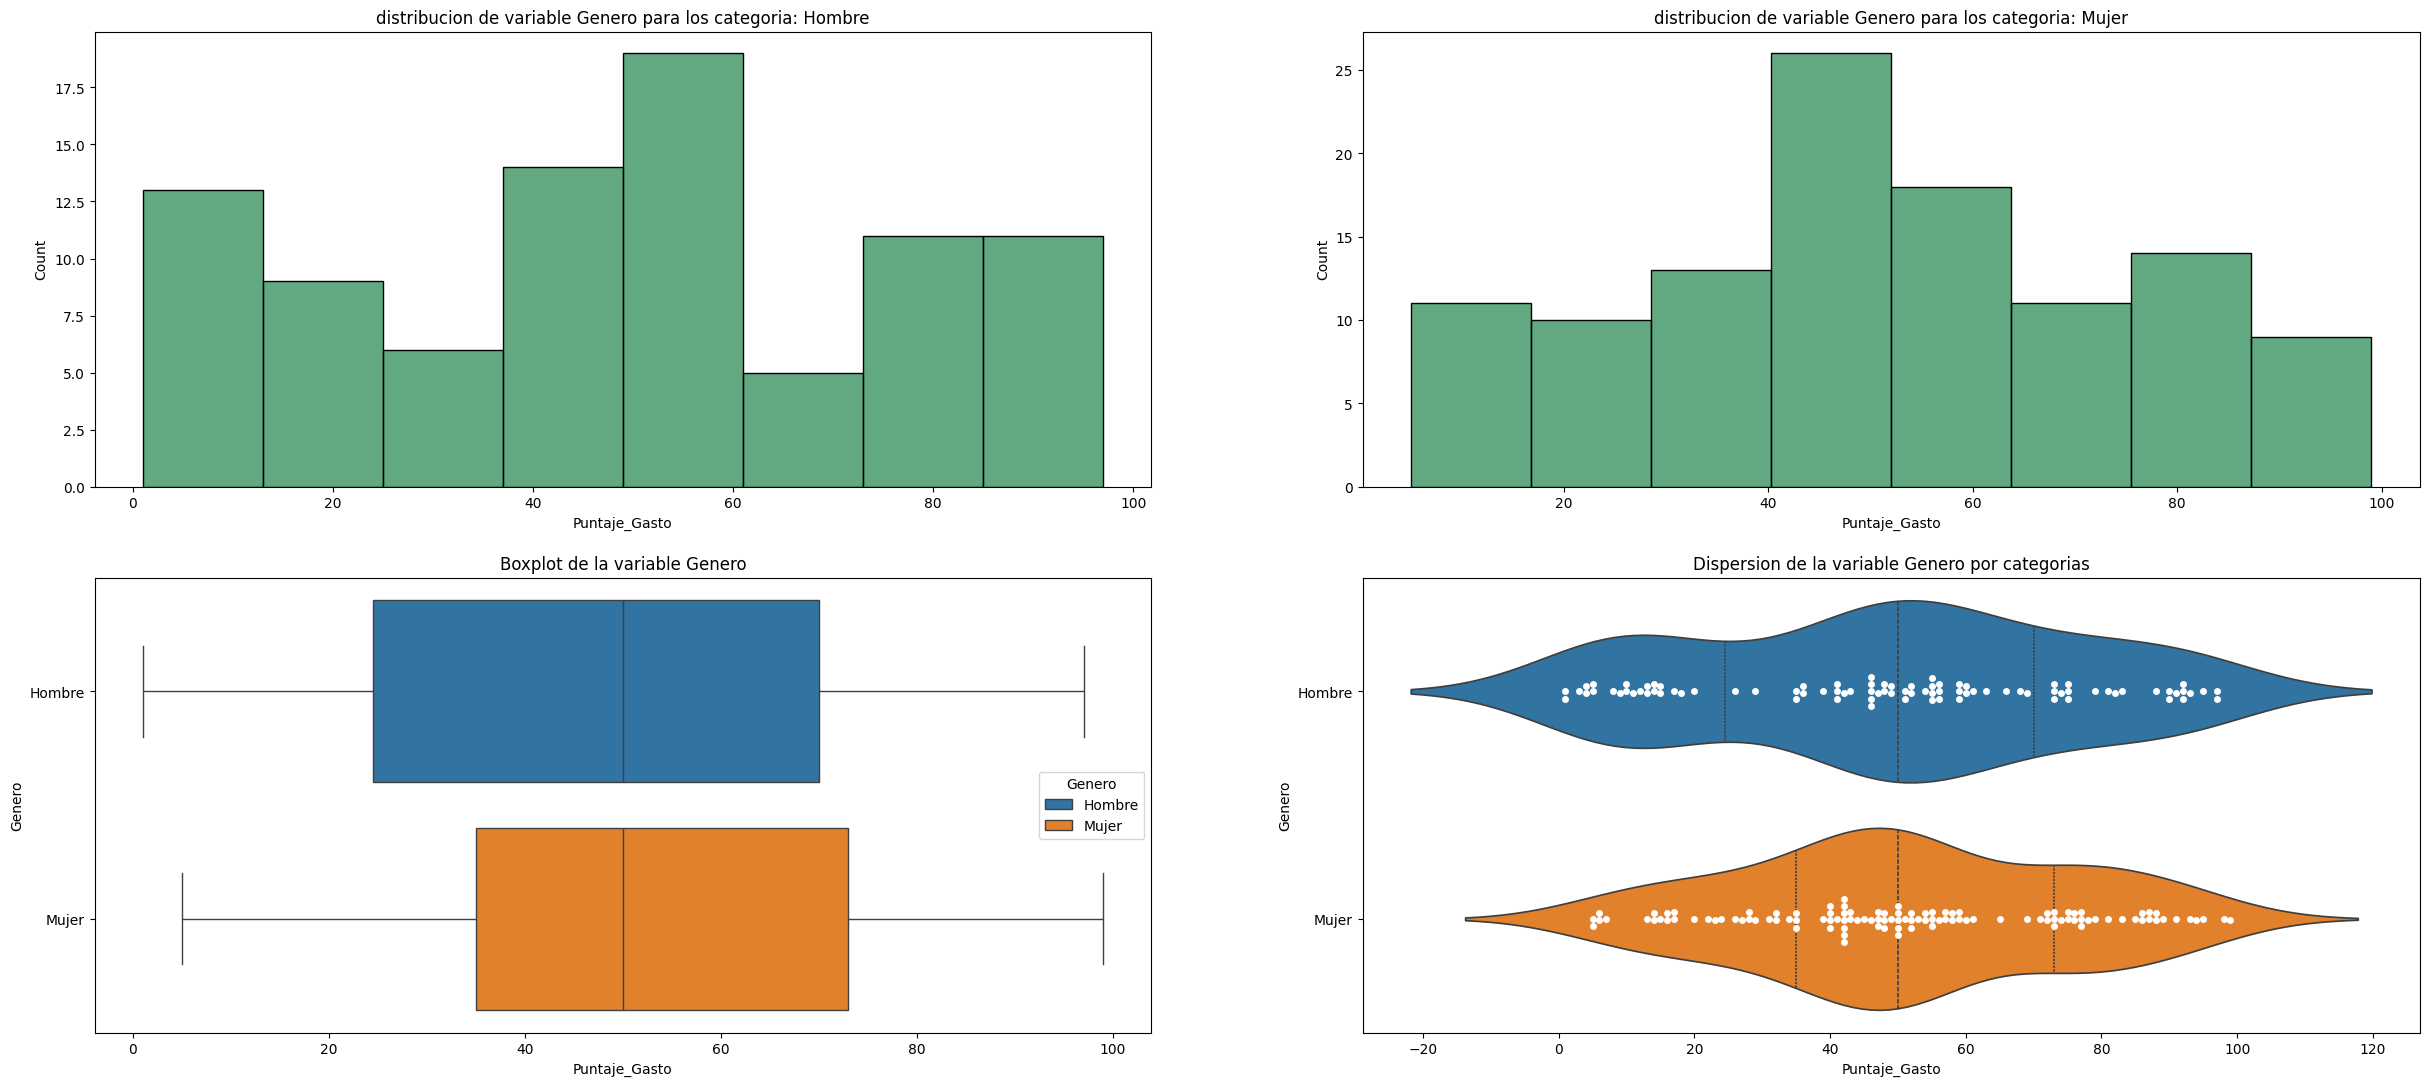

In [22]:
describe_variables(df_datos,"Puntaje_Gasto",grupo="Genero")

Ahora vemos el puntaje de gasto vs el genero. En promedio el genero no parece diferenciar fuertemente el gasto, pero la media es un poco mas alta para mujeres. Ademas tiene un max de 99 mientras que hombres tienen uno de  97. 

Puntaje_Gasto                                                  \
                     count       mean        std   min    25%   50%    75%   
rango_edades                                                                 
1. 18-24              35.0  56.257143  24.659258   5.0  44.00  55.0  76.50   
2. 25-34              54.0  63.166667  24.283506   1.0  47.75  70.0  82.75   
3. 35-44              42.0  49.428571  30.700078   1.0  21.50  41.0  75.75   
4. 45-54              39.0  36.230769  16.261776   4.0  25.00  42.0  47.50   
5. 55-64              16.0  32.312500  21.752299   3.0  13.25  39.0  51.00   
6. 65+                14.0  46.714286  11.431593  14.0  43.75  49.0  54.25   

                    
               max  
rango_edades        
1. 18-24      94.0  
2. 25-34      97.0  
3. 35-44      99.0  
4. 45-54      59.0  
5. 55-64      60.0  
6. 65+        59.0

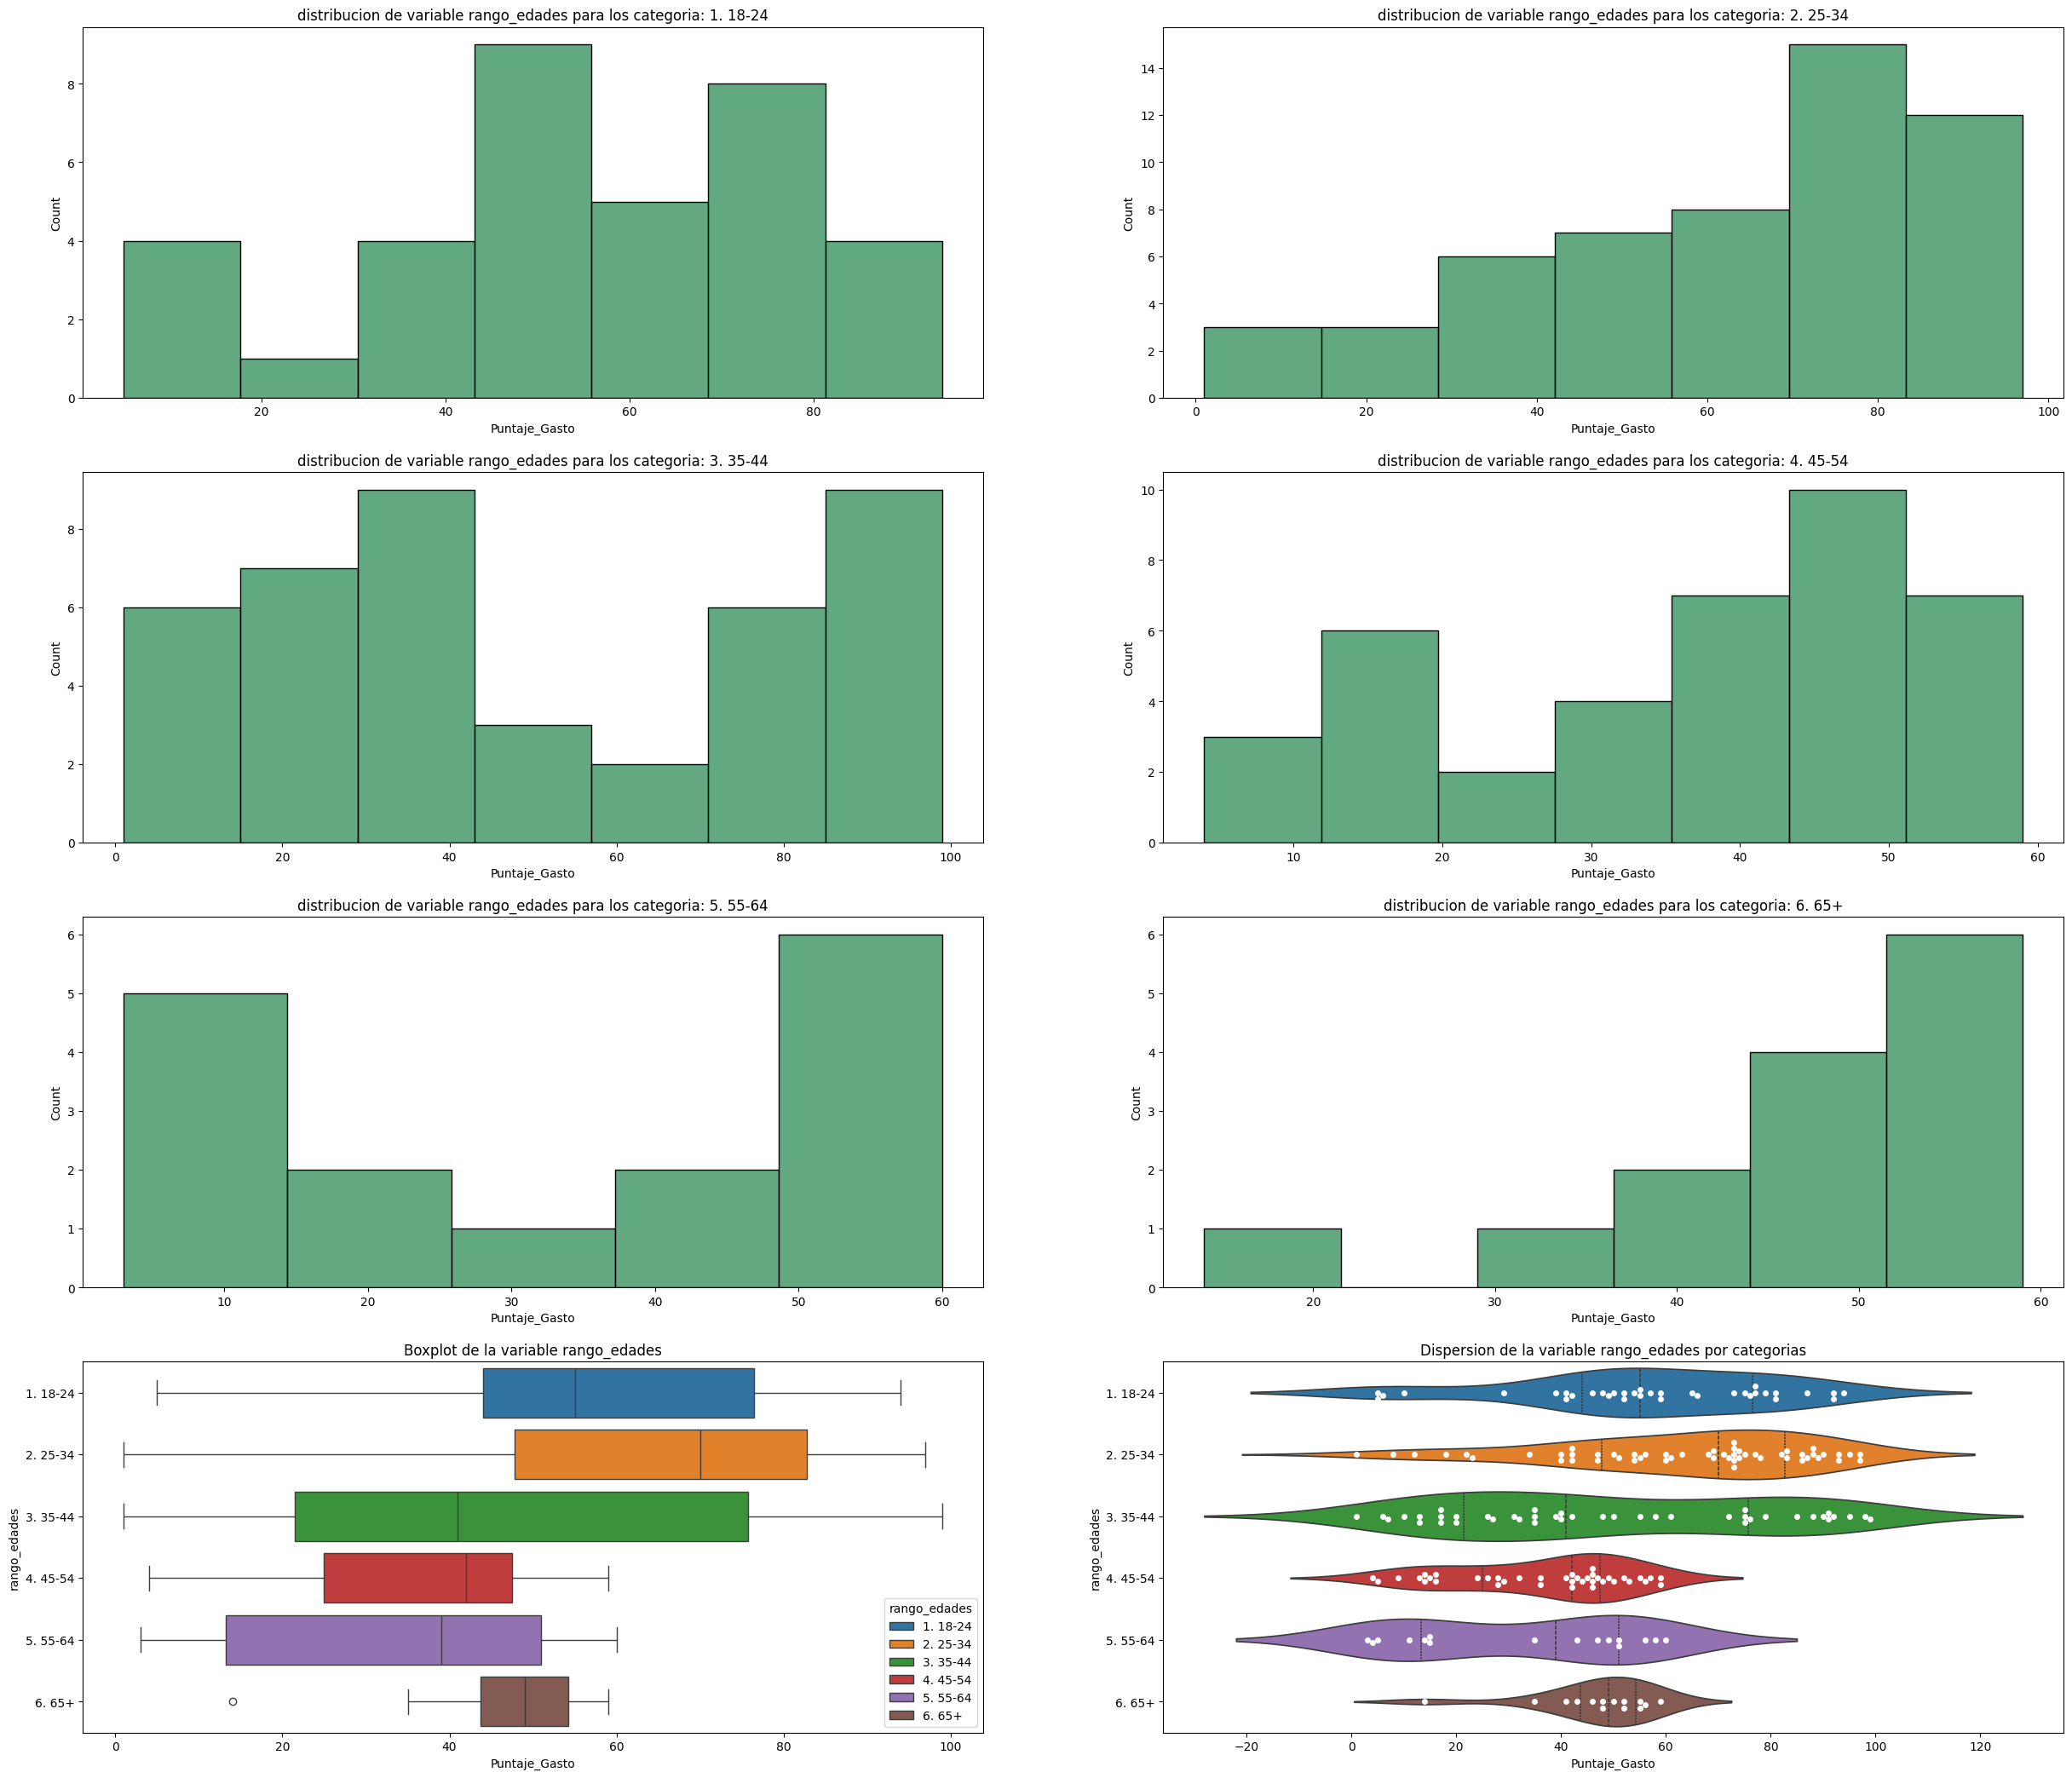

In [23]:
describe_variables(df_datos,"Puntaje_Gasto",grupo="rango_edades")

En el rango de edades vs puntaje de gastos vemos que llos de 25-34 son los que mas suelen gastar comprando con una media de 63 en puntaje

In [24]:
df_datos.columns

Index(['Id_Cliente', 'Genero', 'Edad', 'Ingreso', 'Puntaje_Gasto',
       'rango_edades'],
      dtype='object')

In [25]:
df_datos["edades_genero"] = df_datos["rango_edades"] + "-" + df_datos["Genero"]

Ingreso                                                    \
                  count          mean           std       min         25%   
edades_genero                                                               
1. 18-24-Hombre    16.0  46748.482500  21515.089905  13458.02  29984.6525   
1. 18-24-Mujer     19.0  42523.269474  19749.373173  15766.84  23830.8250   
2. 25-34-Hombre    22.0  78927.434545  32734.446993  22531.85  61793.4150   
2. 25-34-Mujer     32.0  65815.380000  23049.652497  19003.52  46428.2325   
3. 35-44-Hombre    18.0  67001.986111  22499.533107  18797.16  58063.7100   
3. 35-44-Mujer     24.0  66923.430000  31556.048353  19281.75  37553.3550   
4. 45-54-Hombre    14.0  58029.127143  20522.769162  24993.78  43724.2375   
4. 45-54-Mujer     25.0  59210.614800  26541.550152  24402.32  41739.8400   
5. 55-64-Hombre     9.0  55780.227778  25094.510046  18434.74  42262.0400   
5. 55-64-Mujer      7.0  57098.777143  20204.546850  19617.67  49946.0550   
6. 65+-Hombre       9.0  51366.806667  14577.260971  18437.21  45222.0600   
6. 65+-Mujer        5.0  51517.958000   9902.628197  37926.15  46970.5400   

                                                   
                       50%         75%        max  
edades_genero                                      
1. 18-24-Hombre  47652.490  60447.4525   80360.65  
1. 18-24-Mujer   38599.280  61699.1550   71427.64  
2. 25-34-Hombre  77390.985  96065.5225  138584.52  
2. 25-34-Mujer   72515.755  78621.0625  103654.79  
3. 35-44-Hombre  71638.860  83590.7100   91426.18  
3. 35-44-Mujer   72184.815  89797.3150  119534.68  
4. 45-54-Hombre  60761.560  69593.5850   97525.80  
4. 45-54-Mujer   54827.740  67219.4800  126685.78  
5. 55-64-Hombre  54475.760  71651.0800   94049.49  
5. 55-64-Mujer   58838.530  70389.0600   80565.01  
6. 65+-Hombre    52200.840  61969.1500   64156.37  
6. 65+-Mujer     50529.760  59872.0800   62291.26

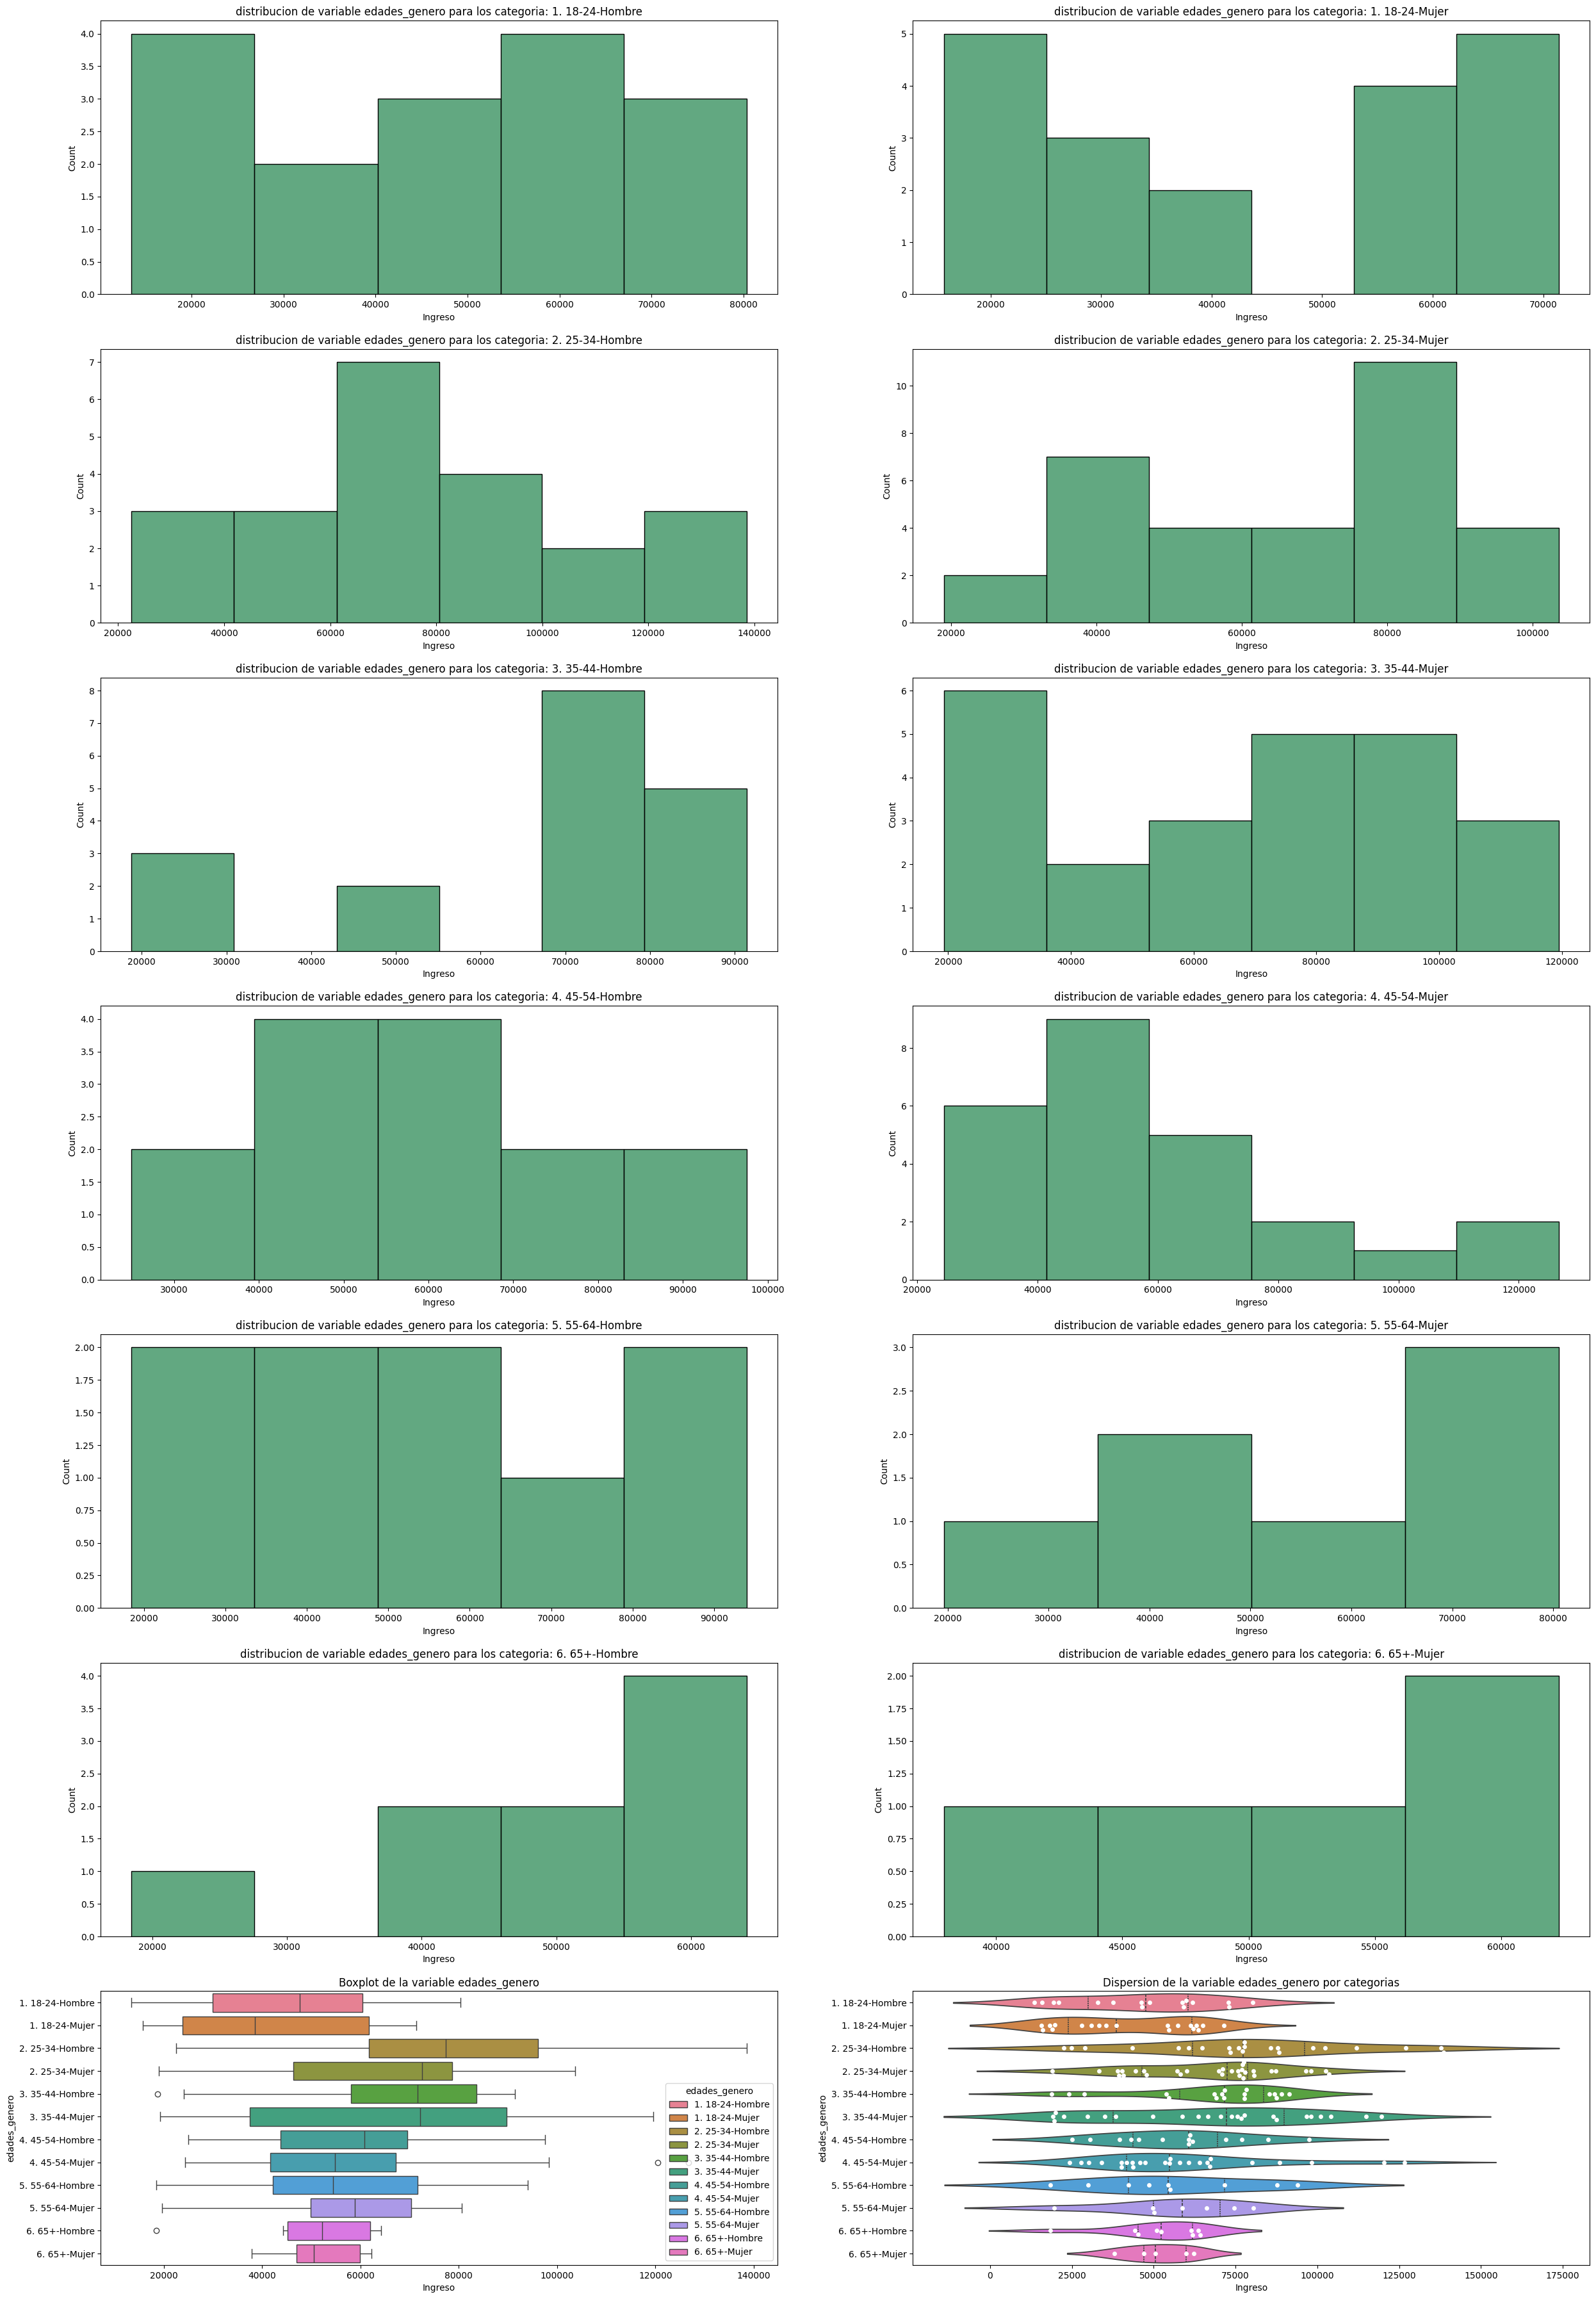

In [26]:
describe_variables(df_datos,variable="Ingreso", grupo="edades_genero")

Ahora se puede ver las edades y el genero y se encuentra que hombres entre 25-34 son aquellos con mayor ingreso promedio y las mujeres entre 18-24 las que tienen menor iungreso promedio.

Puntaje_Gasto                                                  \
                        count       mean        std   min    25%   50%    75%   
edades_genero                                                                   
1. 18-24-Hombre          16.0  51.875000  27.796583   5.0  40.50  53.5  69.25   
1. 18-24-Mujer           19.0  59.947368  21.754881   6.0  49.00  57.0  76.50   
2. 25-34-Hombre          22.0  62.454545  28.468407   1.0  55.25  71.0  80.25   
2. 25-34-Mujer           32.0  63.656250  21.413908  22.0  45.75  70.0  83.75   
3. 35-44-Hombre          18.0  50.777778  33.502512   1.0  17.75  51.5  84.75   
3. 35-44-Mujer           24.0  48.416667  29.120315   6.0  26.75  40.0  75.25   
4. 45-54-Hombre          14.0  34.357143  15.775381   4.0  26.75  38.5  46.00   
4. 45-54-Mujer           25.0  37.280000  16.754402   5.0  24.00  43.0  50.00   
5. 55-64-Hombre           9.0  28.444444  23.173860   3.0  11.00  15.0  51.00   
5. 55-64-Mujer            7.0  37.285714  20.385569   5.0  25.00  43.0  52.50   
6. 65+-Hombre             9.0  46.000000  13.453624  14.0  43.00  48.0  55.00   
6. 65+-Mujer              5.0  48.000000   7.713624  35.0  48.00  50.0  52.00   

                       
                  max  
edades_genero          
1. 18-24-Hombre  92.0  
1. 18-24-Mujer   94.0  
2. 25-34-Hombre  97.0  
2. 25-34-Mujer   95.0  
3. 35-44-Hombre  95.0  
3. 35-44-Mujer   99.0  
4. 45-54-Hombre  56.0  
4. 45-54-Mujer   59.0  
5. 55-64-Hombre  60.0  
5. 55-64-Mujer   58.0  
6. 65+-Hombre    59.0  
6. 65+-Mujer     55.0

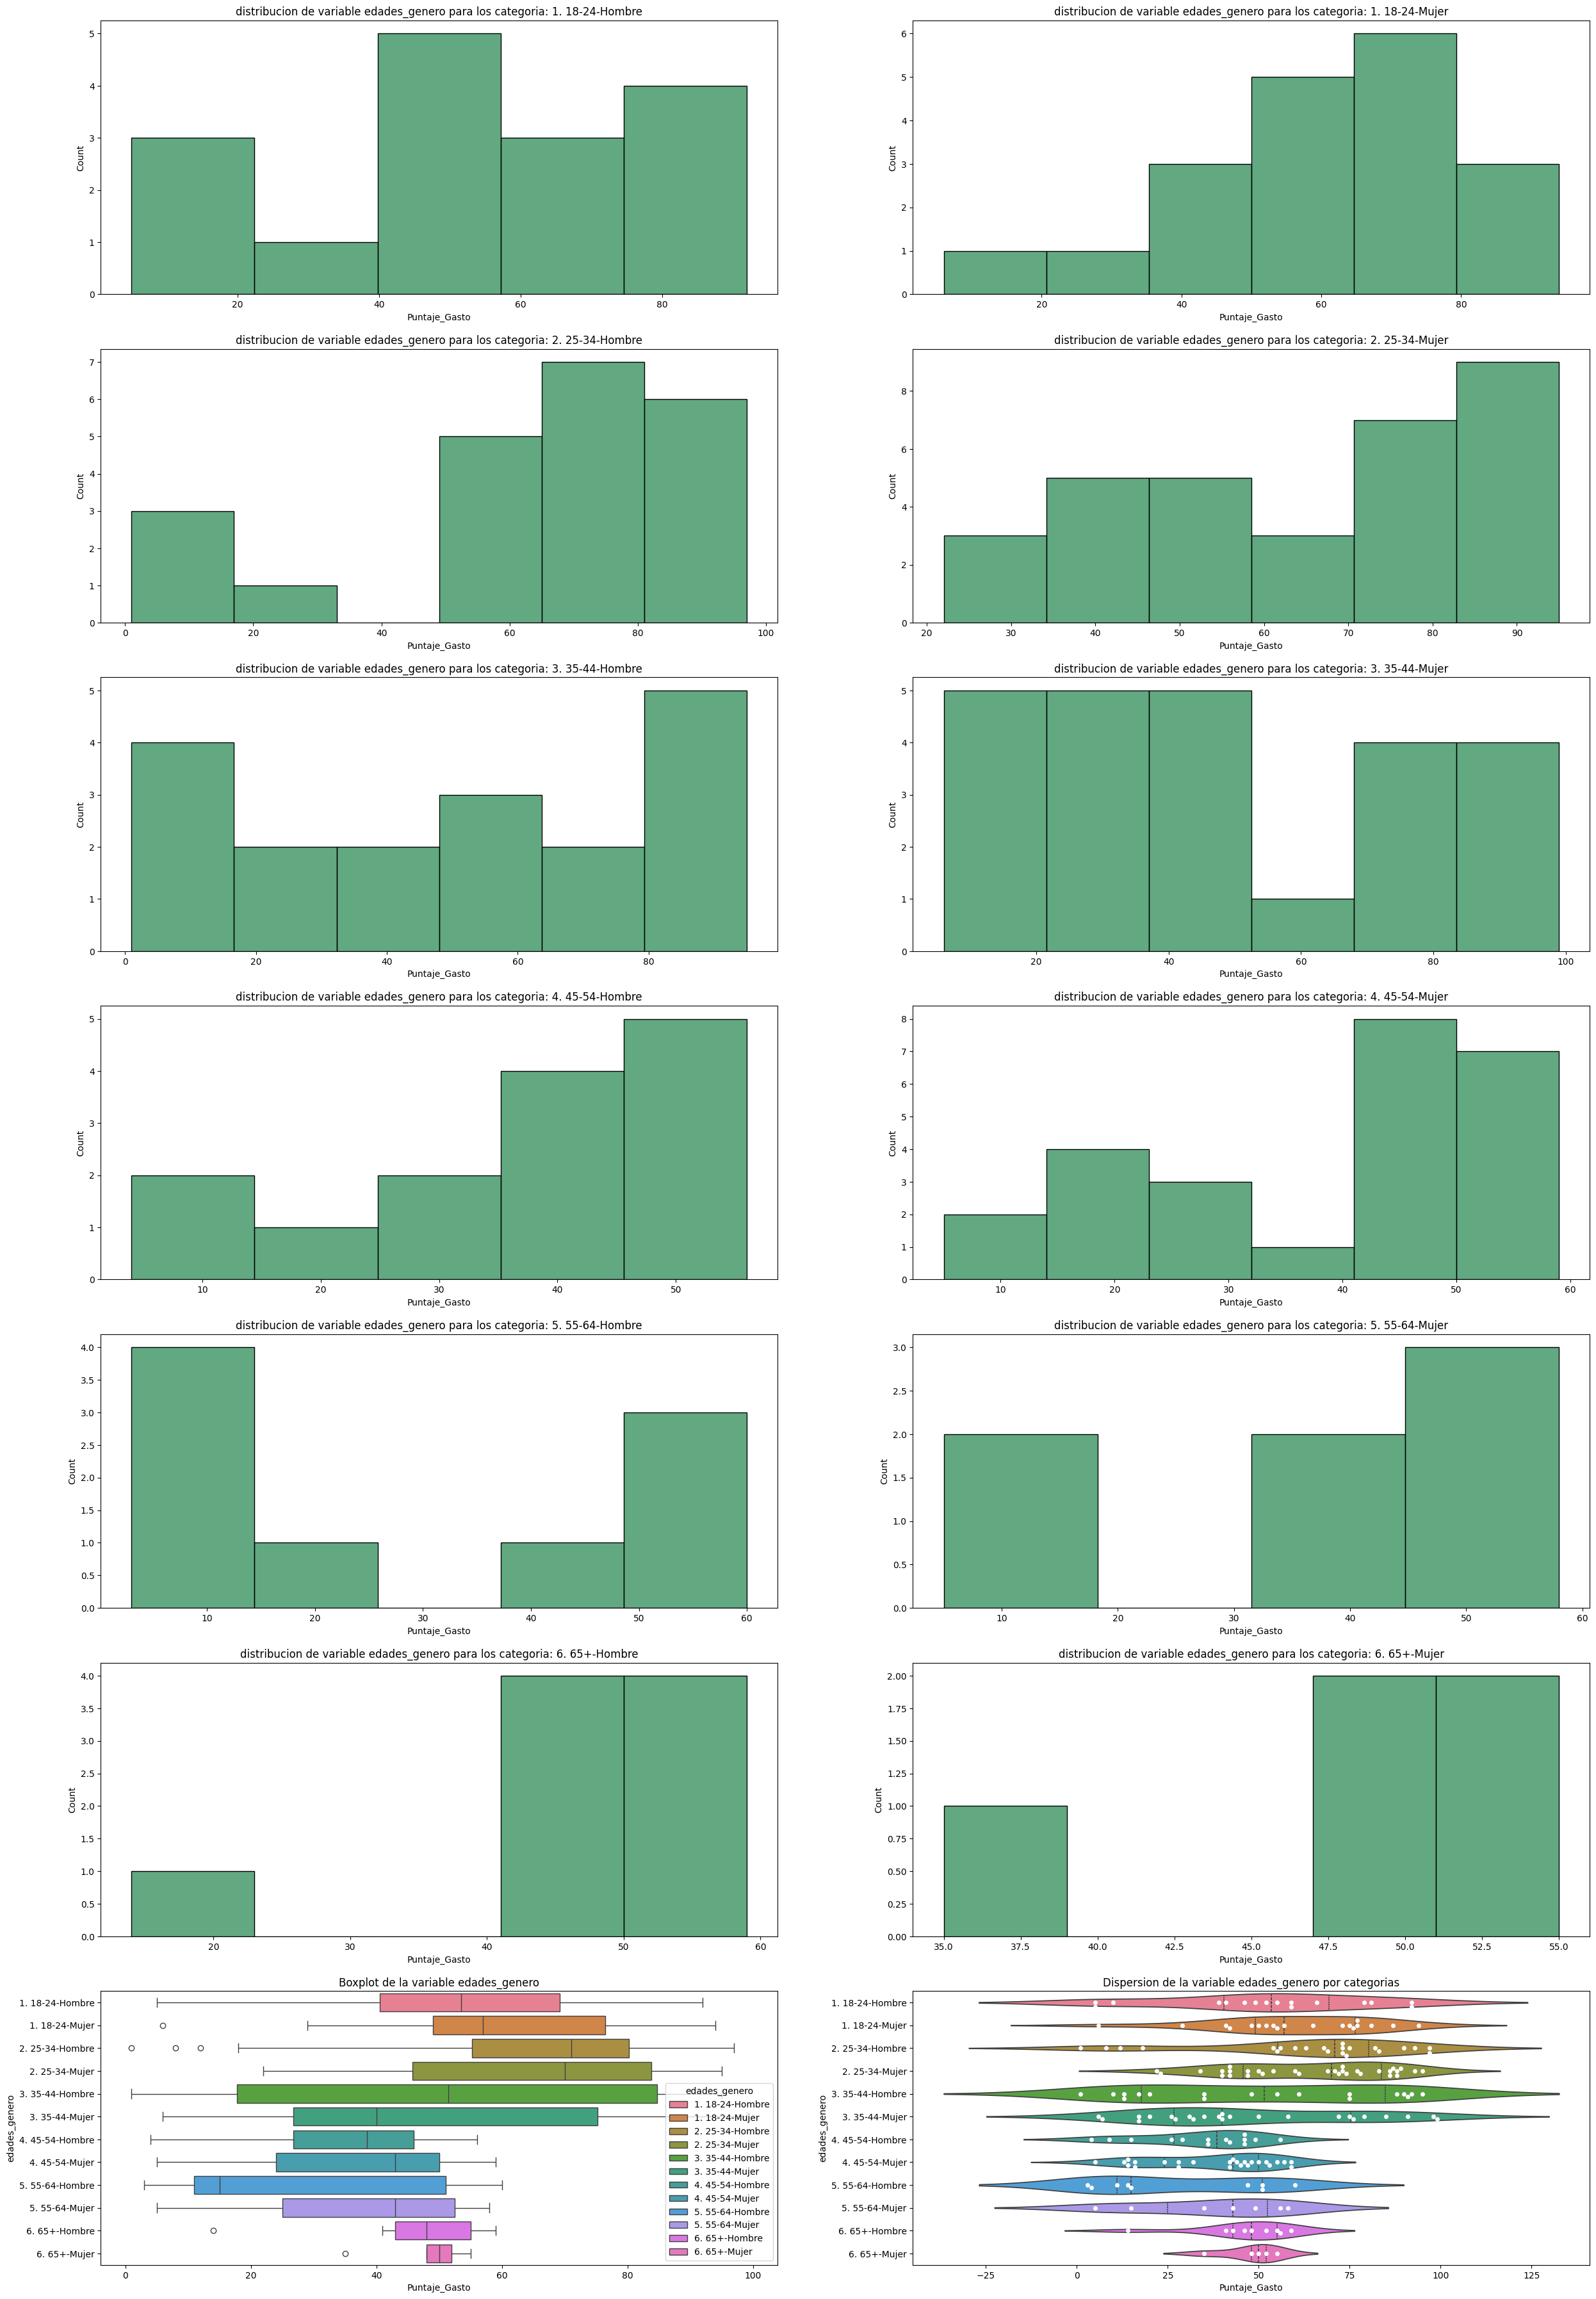

In [27]:
describe_variables(df_datos,"Puntaje_Gasto",grupo="edades_genero")

Viendo el puntaje de gasto, aunque las mujeres entre 18-24 tuvieran el menos ingreso tienen un puntaje de gasto mayor que los hombres de ese mismo rango de edad. Pero al igual que en el ingreso, los hombres de 25-34 tienen un promedio de puntaje de gasto mas alto

<Axes: xlabel='Ingreso', ylabel='Puntaje_Gasto'>

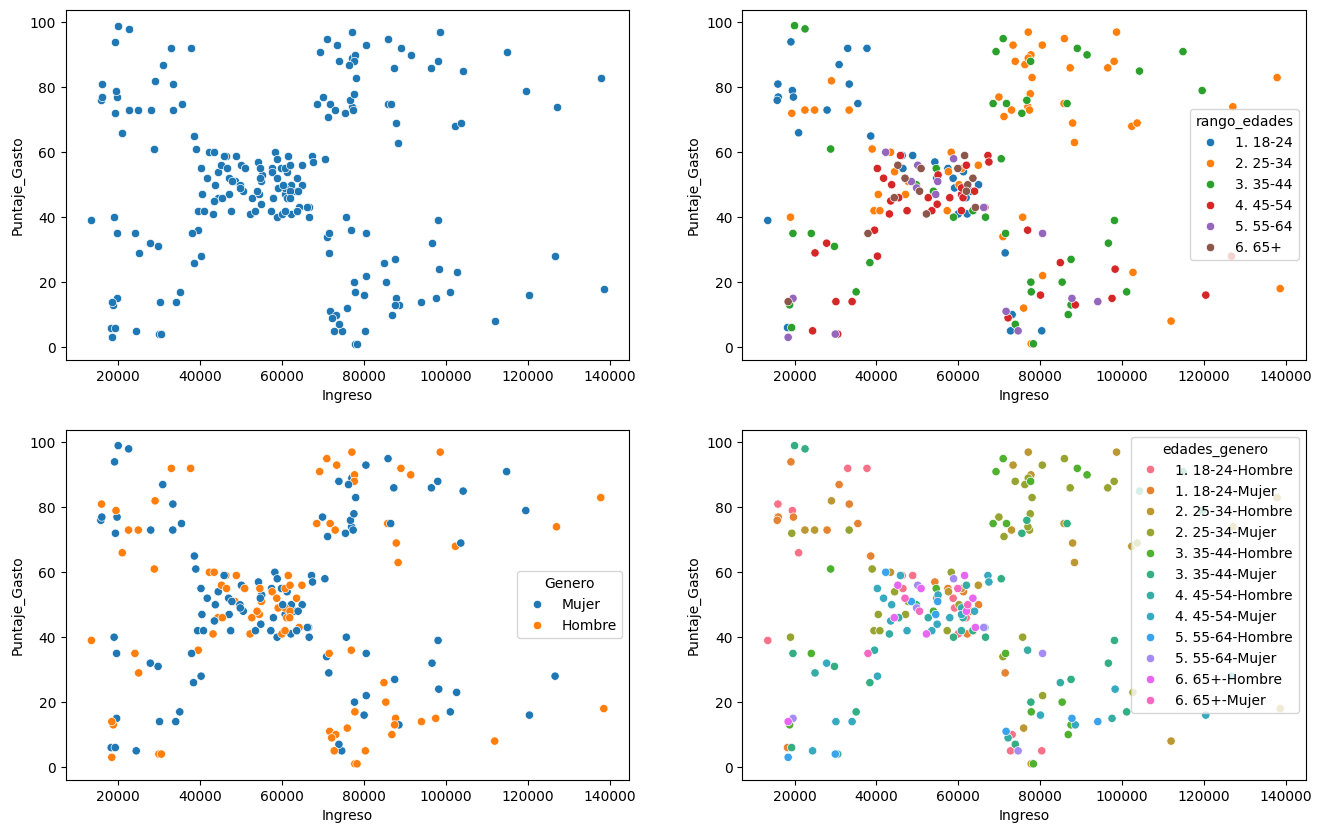

In [28]:
n_rows = 2
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*5))
axs = ax.flatten()

sns.scatterplot(data=df_datos, x="Ingreso",y="Puntaje_Gasto",ax=axs[0])
sns.scatterplot(data=df_datos.sort_values(by="rango_edades"), x="Ingreso",y="Puntaje_Gasto",hue="rango_edades",ax=axs[1])
sns.scatterplot(data=df_datos, x="Ingreso",y="Puntaje_Gasto",hue="Genero",ax=axs[2])
sns.scatterplot(data=df_datos.sort_values("edades_genero"), x="Ingreso",y="Puntaje_Gasto",hue="edades_genero",ax=axs[3])

Podemos ver las variables de puntaje de gasto vs otras variables y definir clusters de las observaciones, a primera vista sin ningun analisis matematico, vemos al menors 5 clusters importantes, Dos arriba, dos abajo y uno en el medio, aunque esto solo es al ojo, habra que hacer un mejor analisis para determinar la realidad

### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

In [29]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from sklearn.preprocessing import StandardScaler

In [30]:
df_datos[["Ingreso","Puntaje_Gasto"]]

Ingreso  Puntaje_Gasto
0    98115.05             39
1    35458.14             75
2    59872.08             55
3    48508.93             51
4    44431.11             54
..        ...            ...
195  19322.17             72
196  43486.37             45
197  24086.95             35
198  38599.28             65
199  86546.01             75

[200 rows x 2 columns]

In [31]:
# Utilice este espacio para escribir el código.
scaler = StandardScaler()
df_datos_scaled = pd.DataFrame(scaler.fit_transform(df_datos[["Ingreso","Puntaje_Gasto"]]))

df_datos_scaled.describe()
# dist = pdist(X, metric='euclidean')
# Z = linkage(dist, method='ward')

0             1
count  2.000000e+02  2.000000e+02
mean  -1.243450e-16 -1.021405e-16
std    1.002509e+00  1.002509e+00
min   -1.800440e+00 -1.910021e+00
25%   -7.295316e-01 -5.997931e-01
50%    5.859924e-03 -7.764312e-03
75%    6.305804e-01  8.851316e-01
max    2.975897e+00  1.894492e+00

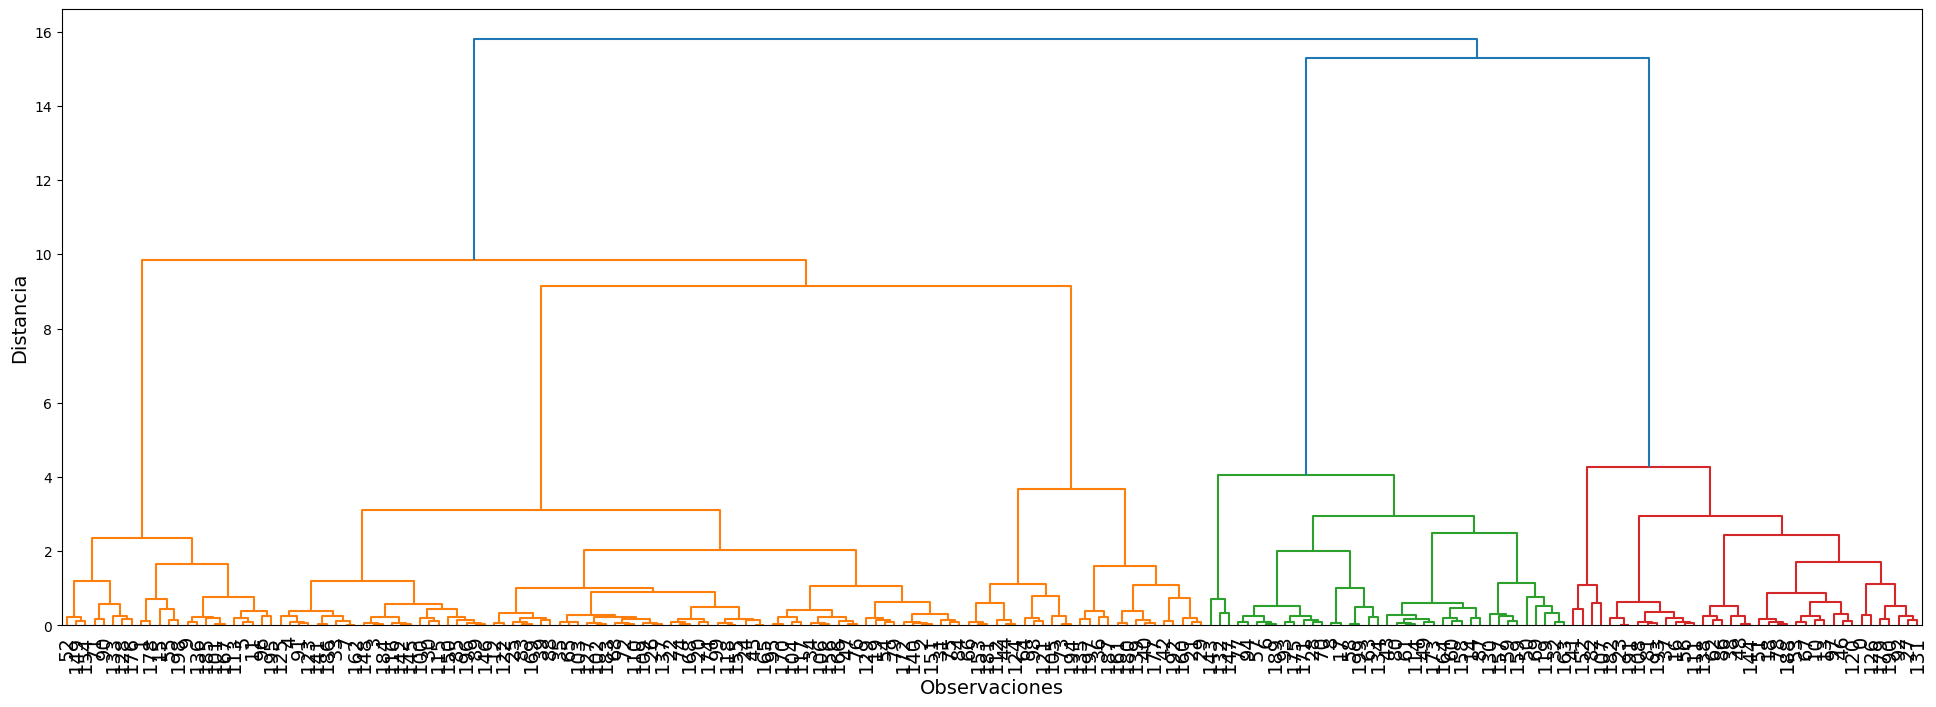

In [32]:
from scipy.cluster.hierarchy import dendrogram

dist = pdist(df_datos_scaled, metric='euclidean')
Z = linkage(dist, method='ward')

fig, ax = plt.subplots(figsize=(24, 8))
d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_ylabel('Distancia', fontsize=14)
plt.show()

Se puede ver entonces como se separan los clusters y a que distancias se juntan estos, gracias al dendograma. A continuacion determinaremos cuantos clusters tomar:

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

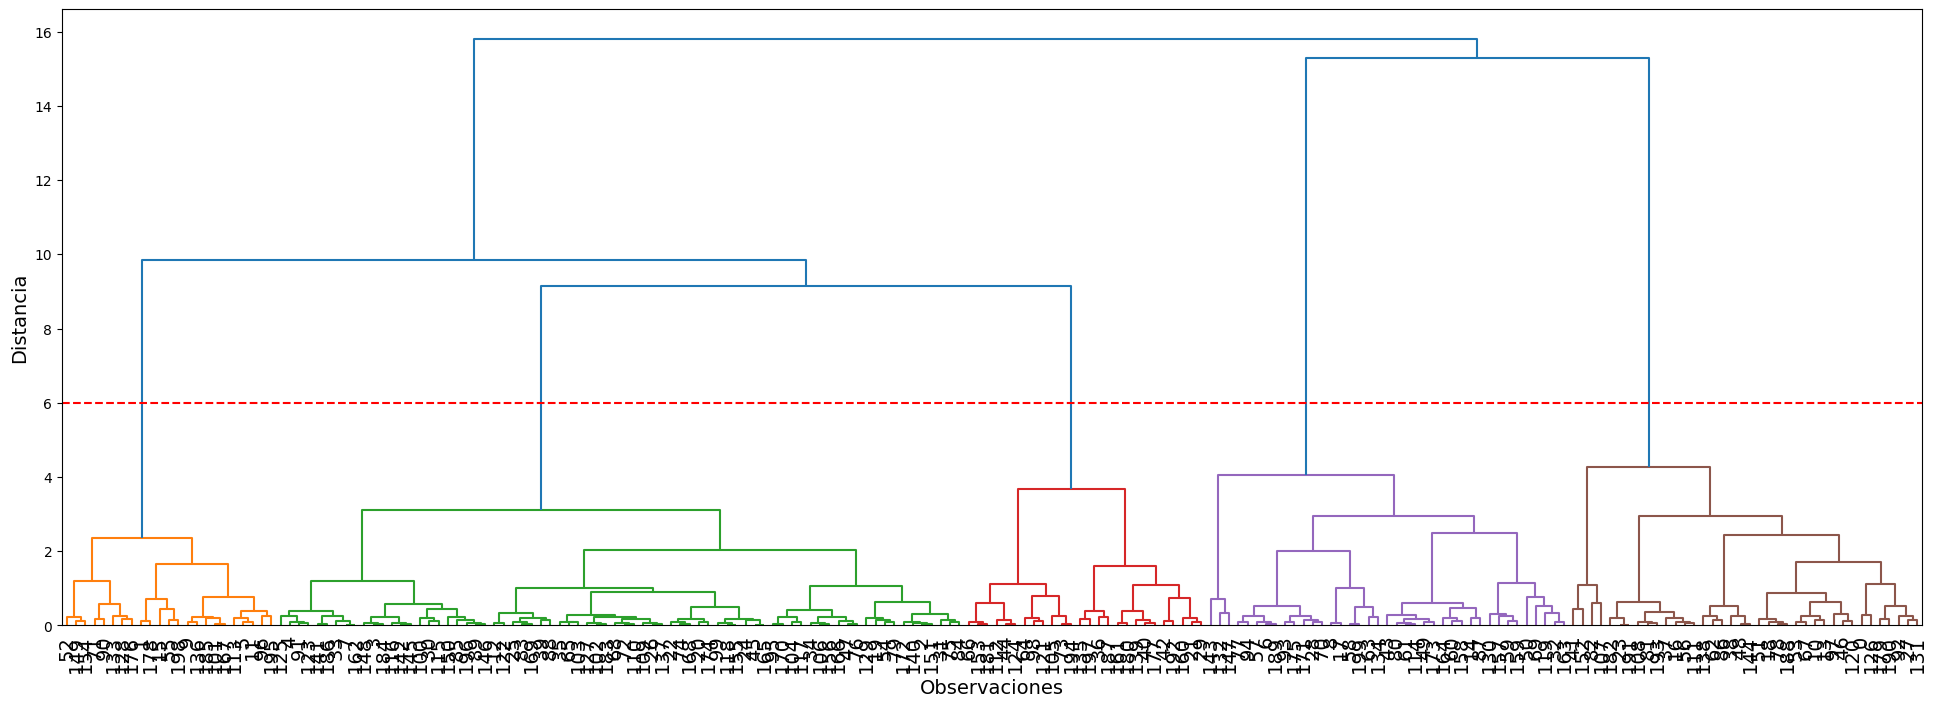

In [33]:
distancia = 6

fig, ax = plt.subplots(figsize=(24, 8))
d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax,color_threshold=distancia)
ax.axhline(y=distancia, color='r', linestyle='--', label="Distnacia fija en = {d}".format(d=distancia))
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_ylabel('Distancia', fontsize=14)
plt.show()

Al dejar distancia en 6, leyendo el dendograma vemos que se toman 5 clusters, que son los que se vieron inicialmente solo al ojo

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

In [34]:
# Utilice este espacio para escribir el código.
from sklearn.cluster import AgglomerativeClustering

cluster_AggC = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')

cluster_sk = cluster_AggC.fit_predict(df_datos_scaled)


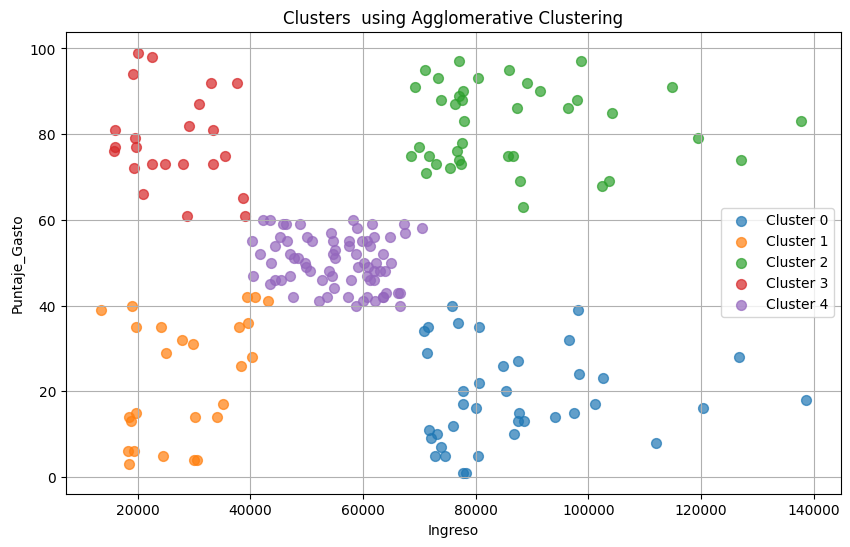

In [35]:
def plot_clusters_aggc(df, cluster_labels):
    plt.figure(figsize=(10, 6))
    unique_clusters = np.unique(cluster_labels)
    for cluster in unique_clusters:
        plt.scatter(
            df.loc[cluster_labels == cluster, 'Ingreso'],
            df.loc[cluster_labels == cluster, 'Puntaje_Gasto'],
            label=f'Cluster {cluster}',
            s=50, alpha=0.7
        )
    plt.title('Clusters  using Agglomerative Clustering')
    plt.xlabel('Ingreso')
    plt.ylabel('Puntaje_Gasto')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_clusters_aggc(df_datos, cluster_sk)

Se puede ver entonces que usando 5 clusters (encontrados gracias a una distancia de 6) se divide como lo vimos inicialmente al ojo en 5 clusters. Lo que nos puede decir que estos grupos de personas se pueden clasificar por ingresoso y puntaje de gasto en 5 grupos diferentes.

##### Donde enfocar el marketing
Enfocaria una estrategia de marketing en los clusters 0 y 4:

* En el cluster 0 tienen un alto ingreso pero bajo puntaje de gasto, por lo que tienen los medios para comprar pero no hacen tantas compras, si enfocamos una campaña de marketing a este grupo podriamos hacer que el puntaje de gasto aumente.

* El cluster 4 aunque con menores ingresos que el cluster 0 tiene mejor puntaje de gasto, y seria posible hacer que aprovechando su capacidad monetaria aumenten aun mas su puntaje de gasto parecido a los clusters 2 y 3.


Los demas clusters no valdria la pena utilizar recursos en ellos, pues por ejemplo los cluster 2 y 3 ya tienen un puntaje de gasto alto, y el cluster 1 pueden no tener los medios para subir mucho mas el puntaje de gasto (aunque podria ser posible buscar de que forma hacer que suban al cluster 3, pero puede ser mas dificil solo con marketing) 

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

In [36]:
# Utilice este espacio para escribir el código.
X=df_datos_scaled


#### Eleccion `eps`: Find Knee Points

In [37]:

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

def find_knee_points(data, n_neighbors_list, metric='minkowski'):
    knee_values = []
    
    # Definir una lista de colores usando la paleta "tab10"
    colors = plt.cm.tab10(np.linspace(0, 1, len(n_neighbors_list)))
    
    plt.figure(figsize=(10, 6), dpi=100)
    
    for idx, n in enumerate(n_neighbors_list):
        # Crear el modelo de vecinos más cercanos
        neigh = NearestNeighbors(n_neighbors=n, metric=metric)
        nbrs = neigh.fit(data)
        distancias, indices = nbrs.kneighbors(data)
        distancias = np.sort(distancias.flatten())
        
        # Calculo de rodilla
        i = np.arange(len(distancias))
        knee_locator = KneeLocator(i, distancias, curve='convex', direction='increasing')
        
        # Verificar si se encontró un punto de rodilla
        if knee_locator.elbow is not None:
            knee_value = distancias[knee_locator.elbow]
        else:
            knee_value = np.nan  # En caso de que no se encuentre un punto de rodilla
        
        knee_values.append(knee_value)
        
        # Obtener un color para la línea
        color = colors[idx]
        
        plt.plot(distancias, label=f'n_neighbors = {n}', color=color)
        if not np.isnan(knee_value):
            plt.axhline(y=knee_value, color=color, linestyle='--', label=f'Knee at {n} = {knee_value:.2f}')

    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.title('Knee Point Analysis for Different n_neighbors')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    return knee_values

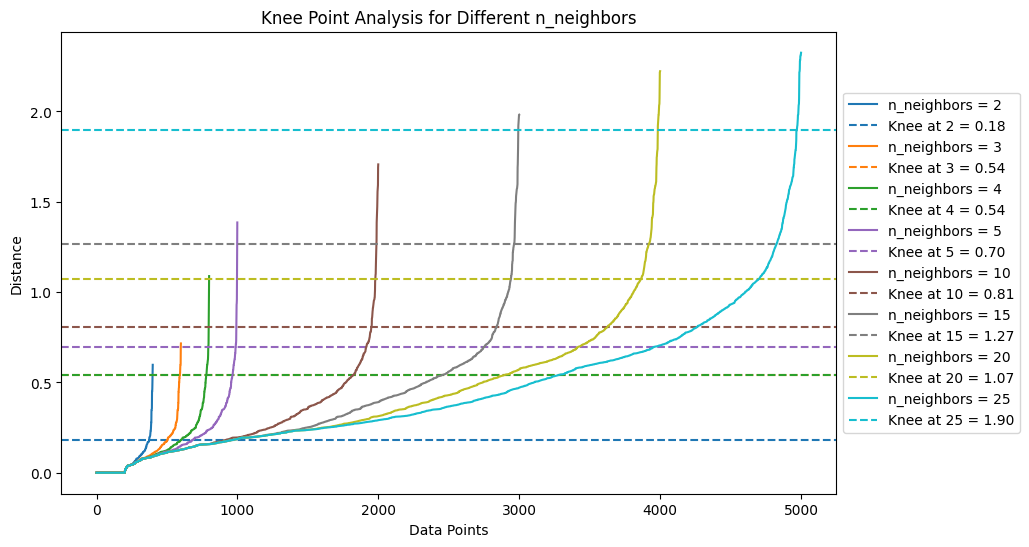

Puntos de rodilla encontrados para diferentes numeros de vecinos:
    n_neighbors   epsilon
0            2  0.179404
1            3  0.541554
2            4  0.541554
3            5  0.697700
4           10  0.807265
5           15  1.268784
6           20  1.073379
7           25  1.895446


In [38]:
n_neighbors_list = [2, 3, 4, 5, 10, 15, 20, 25]  

epsilon_list = find_knee_points(X, n_neighbors_list)

neighbors_epsilon=pd.DataFrame({'n_neighbors':n_neighbors_list, 'epsilon':epsilon_list})

print('Puntos de rodilla encontrados para diferentes numeros de vecinos:\n', neighbors_epsilon)

Observando lo knees, se encuentra que a diferentes numeros de n_neighbors hay diferentes eps, si tomamos un promedio dice que deberia ser tomar eps cerca de 0.5. Sin embargo viendo mas adelante la eleccion de min_samples calculando con diferentes eps se encuentra que usando eps cerca a 0.35-0.4 se encunetran mejores resultados

#### Eleccion `min_samples` y mejores `eps`

Para elegir este parámetro sin embargo no existe un método, la elección depende del conocimiento y experiencia de quien implementa el algoritmo. Sin embargo vamos a ver algunos datos, empezando desde min_samples=4.  `min_samples` debe aumentar con la dimensionalidad de los datos. Para datos con dos dimensiones, se puede utilizar el valor de `min_samples=4` sugerido por Ester et al. (1996). Por esta razon empezamos desde aca y veremos como se comporta

In [69]:
def plot_dbscan_across_epsilons(data, epsilon_list, min_samples_list, metric='euclidean'):
    fig, axes = plt.subplots(len(epsilon_list), len(min_samples_list), figsize=(15, len(epsilon_list) * 5), dpi=100)
    
    for i, e in enumerate(epsilon_list):        
        for j, n in enumerate(min_samples_list):
            # Apply DBSCAN with the current epsilon and min_samples
            db = DBSCAN(eps=e, min_samples=n, metric=metric).fit(data)
            cluster_labels = db.labels_
            n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            
            if n_clusters > 1:
                silhouette_avg = silhouette_score(data, cluster_labels)
            else:
                silhouette_avg = np.nan
            
            # Assign clusters to the dataframe
            resultado = pd.DataFrame(data).assign(Cluster=cluster_labels)
            
            # Plot the clusters
            ax = axes[i, j] if len(epsilon_list) > 1 else axes[j]
            for k in np.unique(cluster_labels):
                if k != -1:
                    ax.scatter(
                        x=resultado.loc[resultado.Cluster == k, 0], 
                        y=resultado.loc[resultado.Cluster == k, 1]
                    )
                else:
                    ax.scatter(
                        x=resultado.loc[resultado.Cluster == k, 0], 
                        y=resultado.loc[resultado.Cluster == k, 1],
                        c="black"
                    )
            ax.set_title(f'eps = {e:.2f}: {n_clusters} clusters, min_samples={n}\nSilhouette = {silhouette_avg:.3f}')
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
    
    plt.tight_layout()
    plt.show()

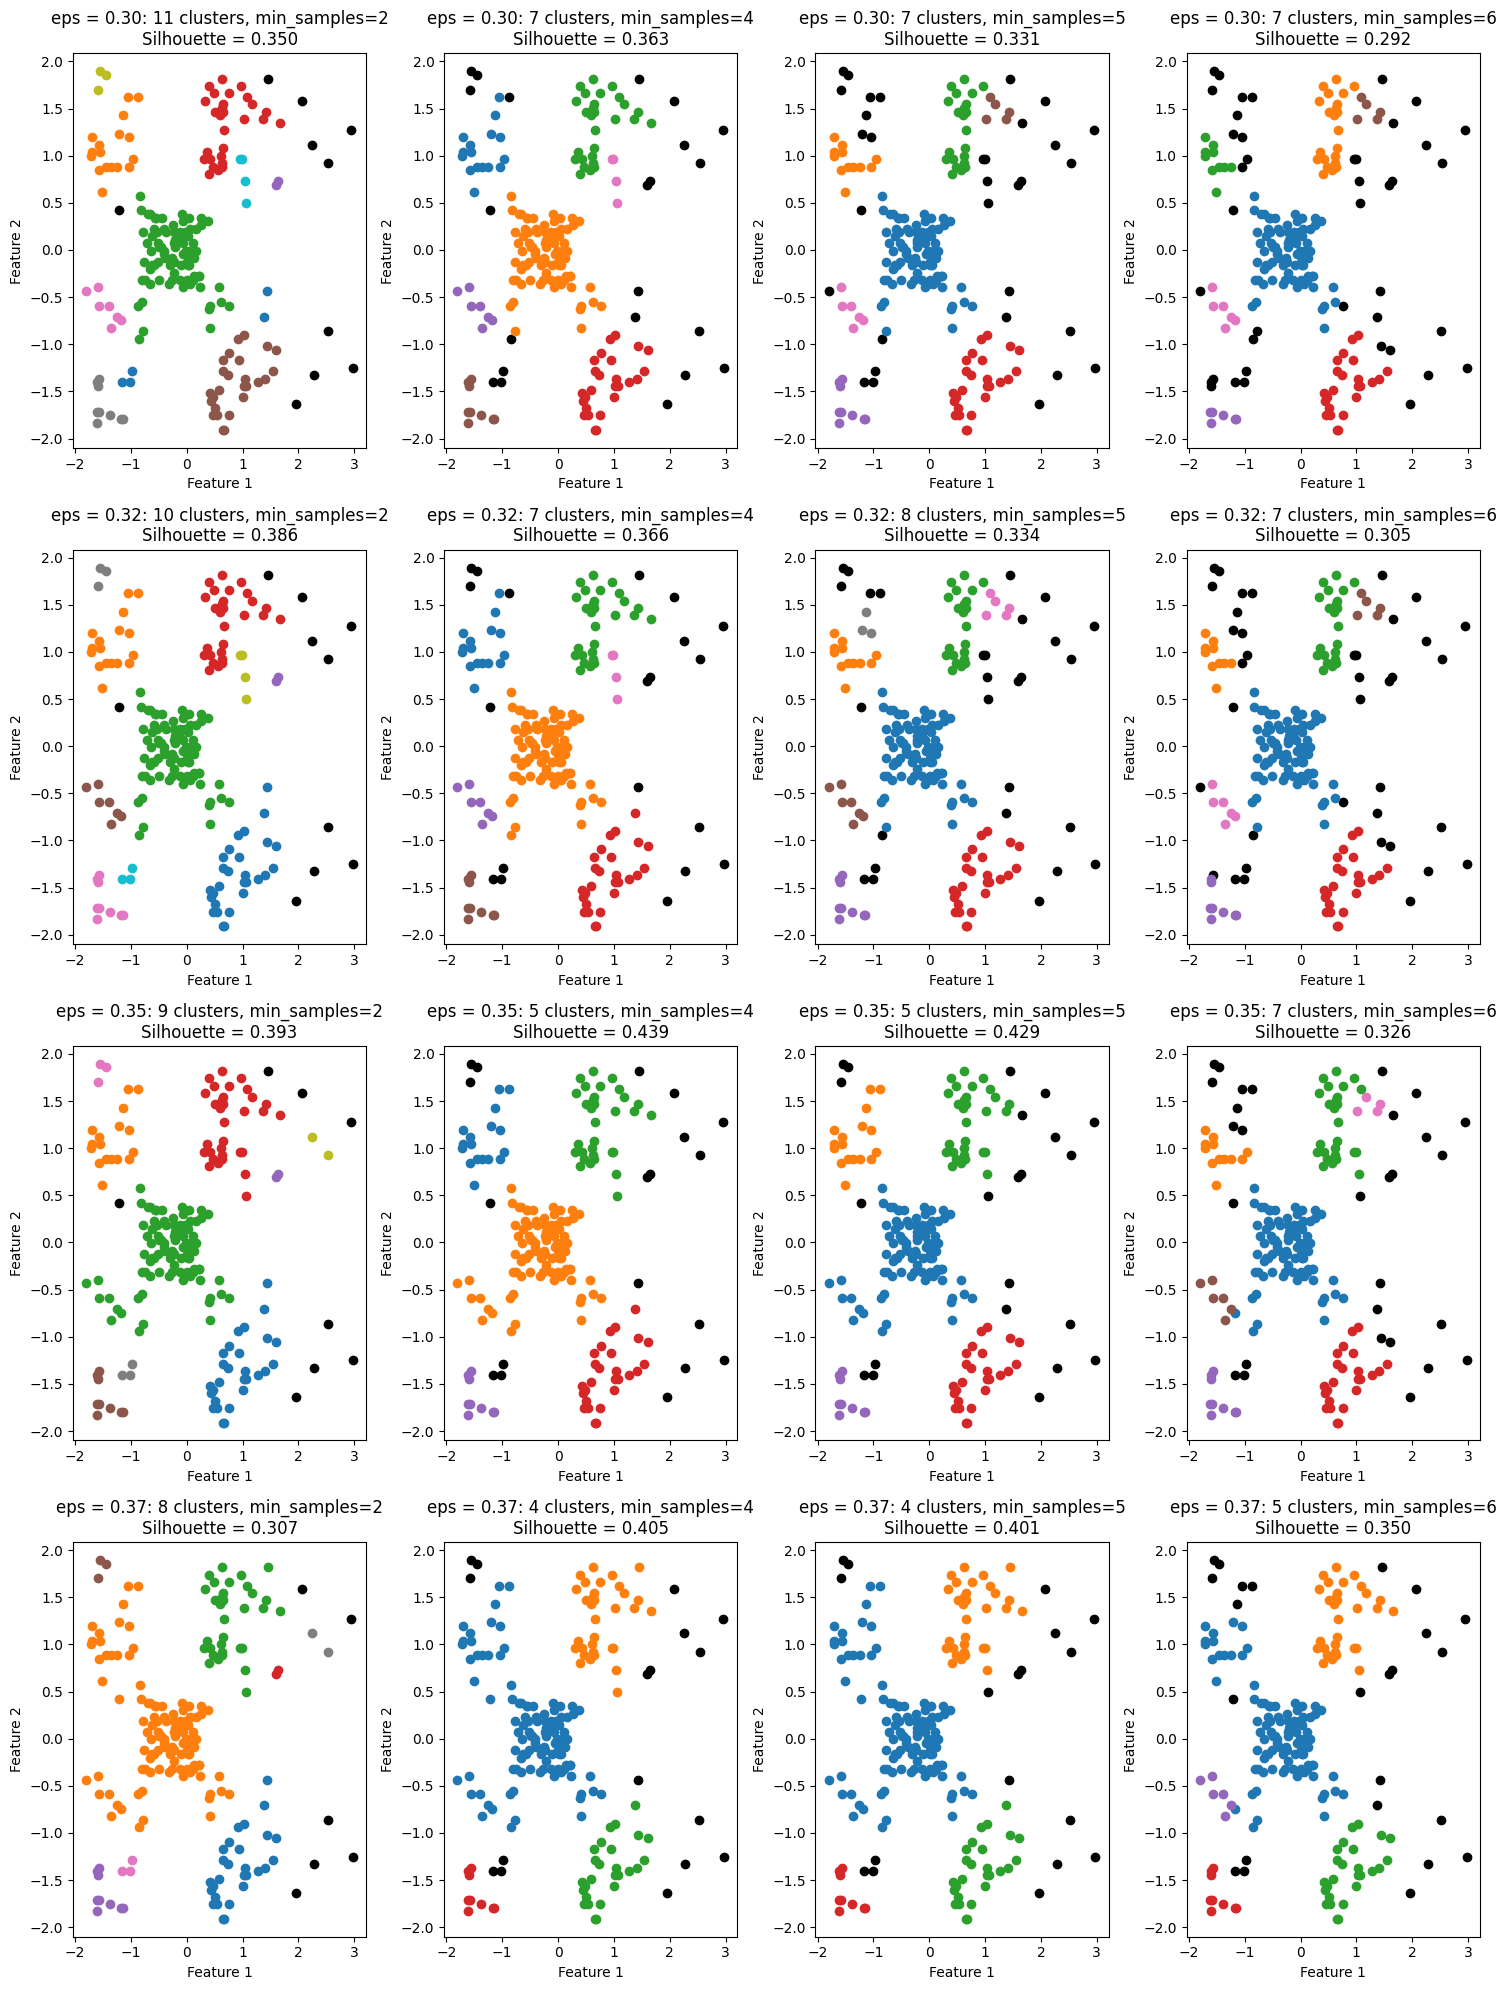

In [70]:
epsilon_list = [0.3 , 0.32 ,0.35, 0.37] 
min_samples_list = [2, 4, 5, 6]  
plot_dbscan_across_epsilons(X, epsilon_list, min_samples_list)

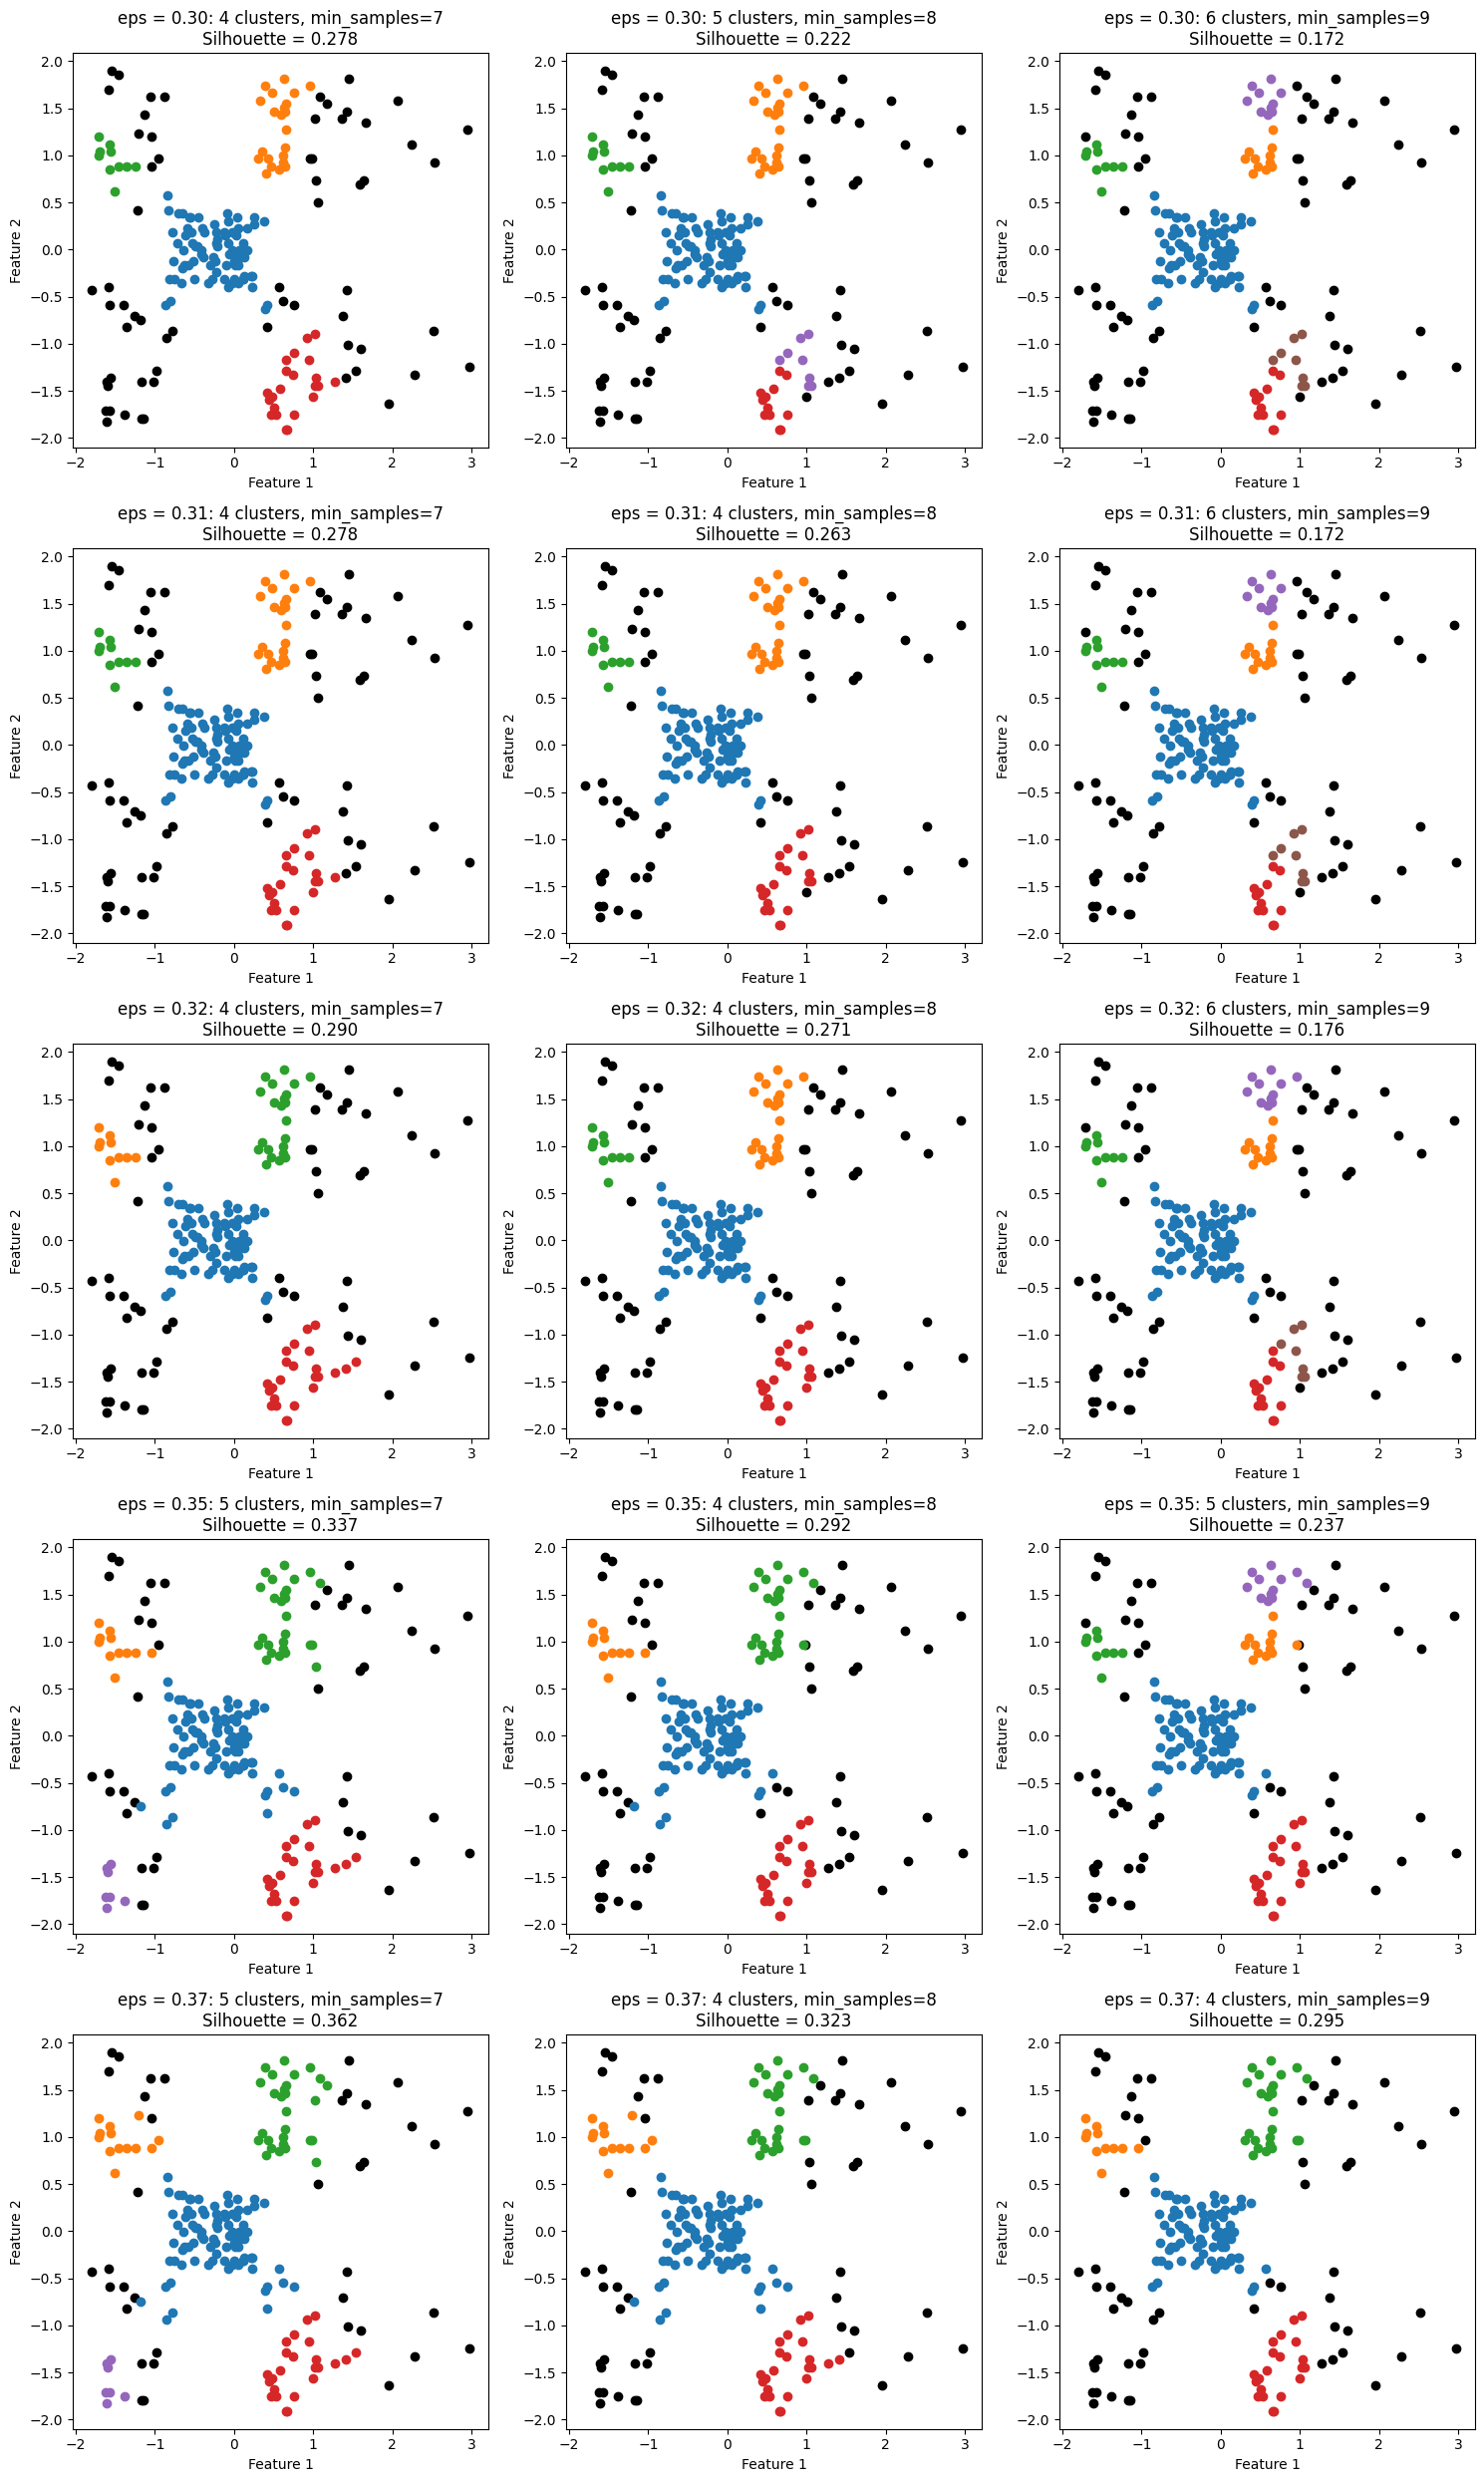

In [71]:
epsilon_list = [0.3, 0.31 , 0.32 ,0.35, 0.37]  
min_samples_list = [7, 8, 9]  
plot_dbscan_across_epsilons(X, epsilon_list, min_samples_list)

#### `Min Samples` y `eps` elegidos:
Vemos entonces que usando min_samples igual a 2 o 4 se encuentran mejores clusters, con menor ruido aunque con mas clusters como se ve a continuacion:

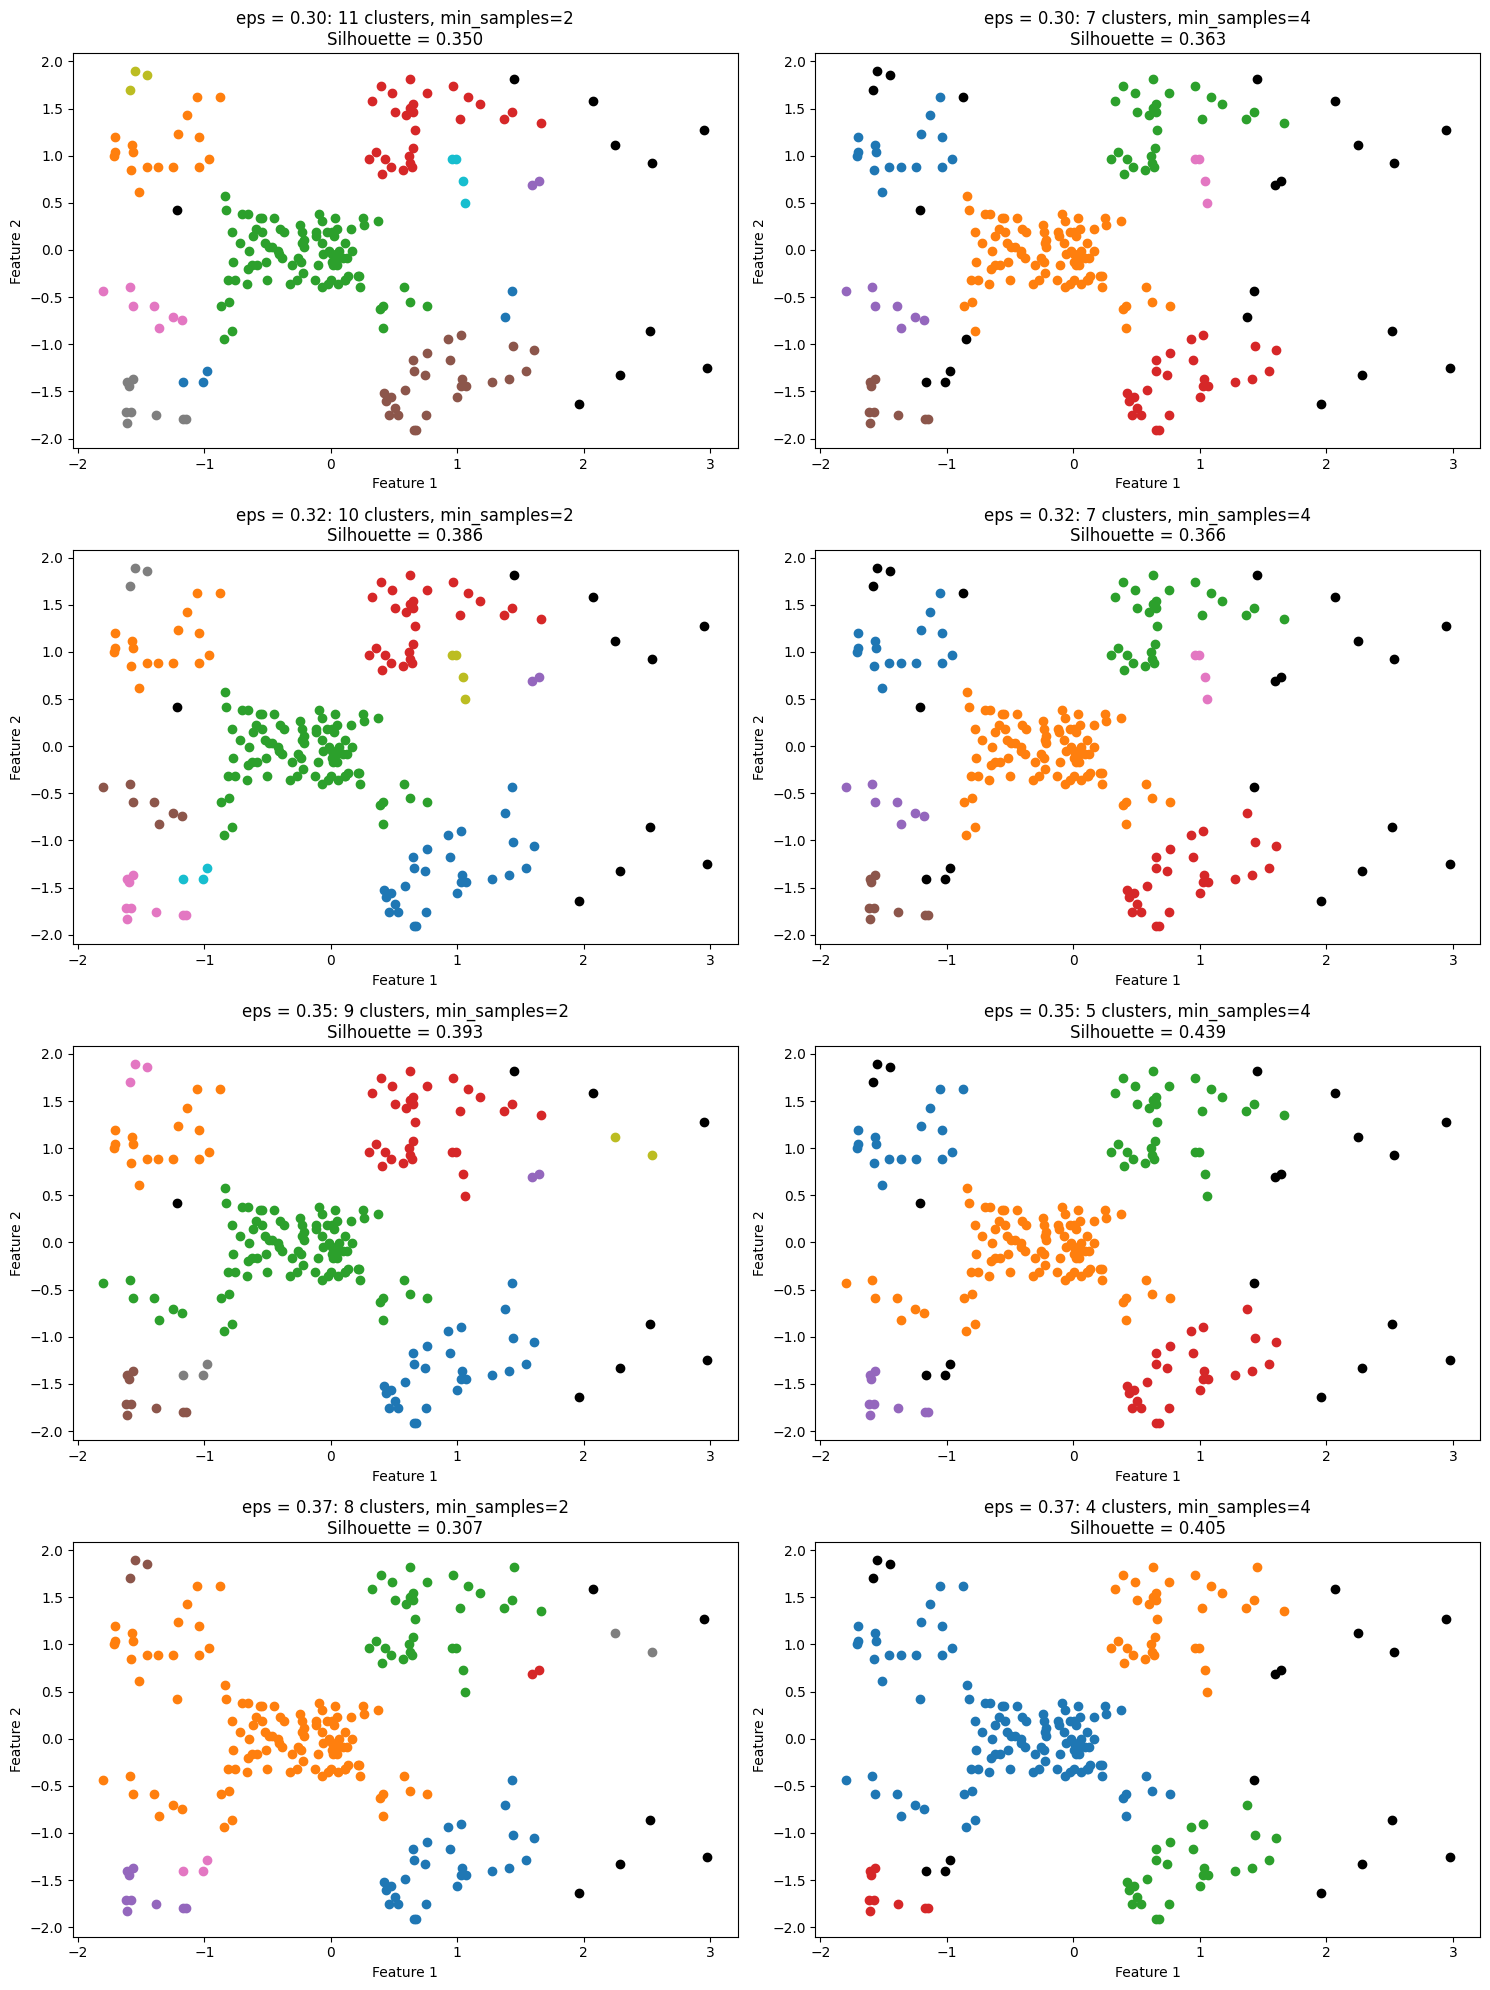

In [72]:
epsilon_list = [0.3, 0.32 ,0.35, 0.37]  
min_samples_list = [2,4]  
plot_dbscan_across_epsilons(X, epsilon_list, min_samples_list)

#### En este caso se decide tomar `min samples` = 4 y `eps` = 0.35 con un Silhoutte de 0.439

Esto debido a que se tiene menor numero de datos de ruido pero aun asi se separa en un numero de clusters trabajables (7), que en este caso podriamos ver que hay algunos con pocas observaciones, pero all agregar mas observaciones se podria separar de mejor manera el grupo de personas. Esto lo podemos ver a continuacion usando DBScan con los datos elegidos:

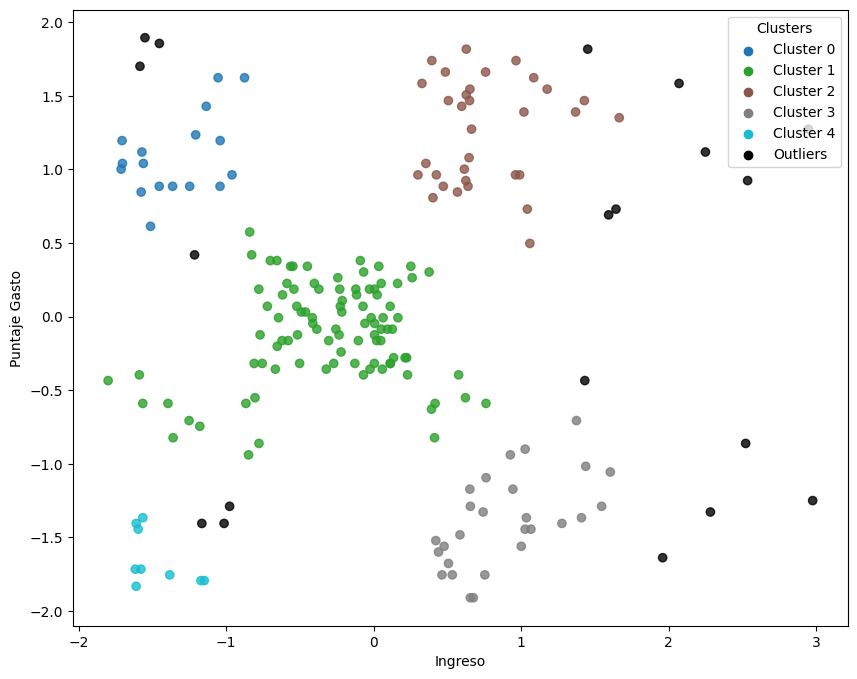

Coeficiente de Silhouette para DBSCAN: 0.439


In [73]:
db = DBSCAN(eps=0.35, min_samples=4)
clusters = db.fit_predict(X)

# Definir número de clusters y paleta de colores
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

# Asignar colores a los puntos según su cluster
cluster_colors = [colors[cluster] if cluster != -1 else (0, 0, 0, 1) for cluster in clusters]

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 8), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=cluster_colors, alpha=0.8)

# Crear leyenda manualmente
for cluster_num in range(num_clusters):
    ax.scatter([], [], c=[colors[cluster_num]], label=f'Cluster {cluster_num}')
if -1 in clusters:
    ax.scatter([], [], c='black', label='Outliers')

ax.set_ylabel("Puntaje Gasto")  # Etiqueta para el eje X usando el nombre de la primera columna
ax.set_xlabel("Ingreso")  # Etiqueta para el eje Y usando el nombre de la segunda columna

ax.legend(loc="upper right", title="Clusters")
plt.show()


if num_clusters > 1:
    silhouette_avg = silhouette_score(X, clusters)
    print(f"Coeficiente de Silhouette para DBSCAN: {silhouette_avg:.3f}")
else:
    print("No se puede calcular el coeficiente de Silhouette con menos de 2 clusters.")

En este caso se obtienen mas clusters, por esta razon se decide cambiar un poco la estrategia de Marketing

##### Donde enfocar el marketing con mas clusters
Enfocaria una estrategia de marketing en los clusters 1(medio), 3(mayor ingreso & bajo puntaje gasto) y 6 (mayor ingreso & medio-alto puntaje de gasto) :


* El cluster 1 aunque con menores ingresos que el cluster 3 tiene mejor puntaje de gasto, y seria posible hacer que aprovechando su capacidad monetaria aumenten aun mas su puntaje de gasto parecido a los clusters de mayor gasto.

* En el cluster 3 tienen un alto ingreso pero bajo puntaje de gasto, por lo que tienen los medios para comprar pero no hacen tantas compras, si enfocamos una campaña de marketing a este grupo podriamos hacer que el puntaje de gasto aumente. Seria una campaña que podria costar mas pero tambien podria dar el mayor retorno si se hace correctamente.

* En el cluster 6 se tiene mismo nivel de ingreso que el 3 pero mayor puntaje de gasto, por lo que podria ser posible subir su nivel de gasto con una estrategia de menor costo

Los demas clusters no valdria la pena utilizar recursos en ellos, pues por ejemplo los cluster 2 y 3 ya tienen un puntaje de gasto alto, y el cluster 1 pueden no tener los medios para subir mucho mas el puntaje de gasto (aunque podria ser posible buscar de que forma hacer que suban al cluster 3, pero puede ser mas dificil solo con marketing) 

### 5. Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

Primero agregamos la categorica de Genero:

In [74]:
df_datos['Genero_Cat']=df_datos['Genero'].map({'Hombre': 0, 'Mujer': 1})
df_datos_cat=df_datos.drop('edades_genero',axis=1)
df_datos_cat = pd.get_dummies(df_datos_cat, columns=['rango_edades'], drop_first=True)
df_datos_cat.head()

Id_Cliente  Genero  Edad   Ingreso  Puntaje_Gasto  Genero_Cat  \
0           1   Mujer    41  98115.05             39           1   
1           2   Mujer    20  35458.14             75           1   
2           3   Mujer    68  59872.08             55           1   
3           4  Hombre    63  48508.93             51           0   
4           5   Mujer    31  44431.11             54           1   

   rango_edades_2. 25-34  rango_edades_3. 35-44  rango_edades_4. 45-54  \
0                  False                   True                  False   
1                  False                  False                  False   
2                  False                  False                  False   
3                  False                  False                  False   
4                   True                  False                  False   

   rango_edades_5. 55-64  rango_edades_6. 65+  
0                  False                False  
1                  False                False  
2                  False                 True  
3                   True                False  
4                  False                False

Luego elegimos unicamente las variables deseadas

In [124]:
X_cat = df_datos_cat[['Ingreso', 'Puntaje_Gasto','Genero'] + df_datos_cat.filter(like='rango_edades').columns.tolist()]
X_cat.head()

Ingreso  Puntaje_Gasto  Genero  rango_edades_2. 25-34  \
0  98115.05             39   Mujer                  False   
1  35458.14             75   Mujer                  False   
2  59872.08             55   Mujer                  False   
3  48508.93             51  Hombre                  False   
4  44431.11             54   Mujer                   True   

   rango_edades_3. 35-44  rango_edades_4. 45-54  rango_edades_5. 55-64  \
0                   True                  False                  False   
1                  False                  False                  False   
2                  False                  False                  False   
3                  False                  False                   True   
4                  False                  False                  False   

   rango_edades_6. 65+  
0                False  
1                False  
2                 True  
3                False  
4                False

Calculamos matriz de distancias con gower para poner en el analisis de knee points, y elegir metric = 'precomputed' para agregar ya la matriz de distancias

In [125]:
print("Matriz original con 2 variables: \n",X.shape)

print("Matriz nueva con 8 variables: \n",X_cat.shape)

Matriz original con 2 variables: 
 (200, 200)
Matriz nueva con 8 variables: 
 (200, 8)


In [126]:
#Matriz con nuevas variables
import gower
dist2 = gower.gower_matrix(X_cat)
dist_mat2 = pd.DataFrame(dist2)
dist_mat2

0         1         2         3         4         5         6    \
0    0.000000  0.233512  0.308612  0.439862  0.322762  0.491503  0.315752   
1    0.233512  0.000000  0.174899  0.293650  0.160750  0.263093  0.167760   
2    0.308612  0.174899  0.000000  0.391454  0.266701  0.432890  0.291330   
3    0.439862  0.293650  0.391454  0.000000  0.382900  0.301641  0.432783   
4    0.322762  0.160750  0.266701  0.382900  0.000000  0.168740  0.058031   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.370805  0.144946  0.312193  0.430943  0.048043  0.131853  0.060155   
196  0.312227  0.171285  0.279124  0.387671  0.262423  0.429276  0.320454   
197  0.204055  0.312380  0.436259  0.294805  0.419558  0.299287  0.477589   
198  0.217619  0.015893  0.159006  0.277757  0.144857  0.273884  0.174826   
199  0.057476  0.176036  0.302157  0.443611  0.318858  0.439129  0.260827   

          7         8         9    ...       190       191       192  \
0    0.327294  0.416219  0.251785  ...  0.274932  0.193239  0.076243   
1    0.156218  0.325751  0.018273  ...  0.258444  0.387211  0.190432   
2    0.268682  0.434015  0.193172  ...  0.333545  0.462312  0.308447   
3    0.137432  0.325468  0.311922  ...  0.464794  0.343562  0.416994   
4    0.258223  0.200716  0.179022  ...  0.097695  0.476462  0.291746   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.293511  0.213044  0.131776  ...  0.145737  0.524505  0.327725   
196  0.270647  0.463139  0.189558  ...  0.337159  0.465926  0.279323   
197  0.177782  0.370274  0.307933  ...  0.468783  0.097551  0.150771   
198  0.140325  0.317511  0.034166  ...  0.242551  0.371318  0.174951   
199  0.310635  0.399715  0.194309  ...  0.332408  0.227600  0.110604   

          193       194       195       196       197       198       199  
0    0.318708  0.487148  0.370805  0.312227  0.204055  0.217619  0.057476  
1    0.251538  0.345472  0.144946  0.171285  0.312380  0.015893  0.176036  
2    0.326639  0.469351  0.312193  0.279124  0.436259  0.159006  0.302157  
3    0.207889  0.327898  0.430943  0.387671  0.294805  0.277757  0.443611  
4    0.340789  0.452650  0.048043  0.262423  0.419558  0.144857  0.318858  
..        ...       ...       ...       ...       ...       ...       ...  
195  0.388832  0.472943  0.000000  0.308579  0.426954  0.153186  0.320982  
196  0.330253  0.190227  0.308579  0.000000  0.407135  0.155392  0.331281  
197  0.211878  0.295989  0.426954  0.407135  0.000000  0.302763  0.238416  
198  0.235645  0.335855  0.153186  0.155392  0.302763  0.000000  0.185653  
199  0.353069  0.521509  0.320982  0.331281  0.238416  0.185653  0.000000  

[200 rows x 200 columns]

In [127]:
#Matriz original
dist__og = gower.gower_matrix(X)
dist_mat_og = pd.DataFrame(dist__og)
dist_mat_og

0         1         2         3         4         5         6    \
0    0.000000  0.268572  0.190930  0.323041  0.282559  0.362364  0.268388   
1    0.268572  0.000000  0.222001  0.300066  0.224805  0.266468  0.259723   
2    0.190930  0.222001  0.000000  0.284581  0.178996  0.313180  0.209612   
3    0.323041  0.300066  0.284581  0.000000  0.352323  0.218096  0.358959   
4    0.282559  0.224805  0.178996  0.352323  0.000000  0.256112  0.064539   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.283409  0.258880  0.217485  0.346893  0.067255  0.251384  0.073670   
196  0.247894  0.249378  0.152606  0.334452  0.240011  0.373315  0.279916   
197  0.249034  0.304577  0.309336  0.174971  0.386881  0.272080  0.390923   
198  0.280366  0.027861  0.234278  0.295411  0.237924  0.281548  0.272842   
199  0.063849  0.265492  0.188646  0.327827  0.266766  0.354343  0.241067   

          7         8         9    ...       190       191       192  \
0    0.292334  0.366605  0.251962  ...  0.247379  0.264084  0.061540   
1    0.250535  0.301122  0.032931  ...  0.262987  0.354790  0.254769   
2    0.223463  0.323338  0.199655  ...  0.224952  0.325975  0.180233   
3    0.249059  0.234837  0.295673  ...  0.334489  0.223932  0.321961   
4    0.253652  0.260890  0.212900  ...  0.112158  0.397965  0.272318   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.296514  0.256162  0.246974  ...  0.102513  0.400186  0.281339   
196  0.268333  0.381962  0.234772  ...  0.283687  0.373597  0.223683   
197  0.277835  0.278999  0.298871  ...  0.368755  0.083571  0.251550   
198  0.251723  0.313081  0.051780  ...  0.275495  0.362006  0.266564   
199  0.288949  0.358583  0.248655  ...  0.252282  0.264518  0.084676   

          193       194       195       196       197       198       199  
0    0.257544  0.355128  0.283409  0.247894  0.249034  0.280366  0.063849  
1    0.266917  0.344911  0.258880  0.249378  0.304577  0.027861  0.265492  
2    0.252981  0.309111  0.217485  0.152606  0.309336  0.234278  0.188646  
3    0.190305  0.208200  0.346893  0.334452  0.174971  0.295411  0.327827  
4    0.299156  0.388641  0.067255  0.240011  0.386881  0.237924  0.266766  
..        ...       ...       ...       ...       ...       ...       ...  
195  0.312429  0.397539  0.000000  0.279667  0.386484  0.271998  0.257650  
196  0.283107  0.268379  0.279667  0.000000  0.358571  0.254676  0.258181  
197  0.225869  0.235537  0.386484  0.358571  0.000000  0.306384  0.249468  
198  0.267943  0.349103  0.271998  0.254676  0.306384  0.000000  0.277287  
199  0.279105  0.369817  0.257650  0.258181  0.249468  0.277287  0.000000  

[200 rows x 200 columns]

#### Opcion 1 con Dummys
Eleccion `eps`: Find Knee Points

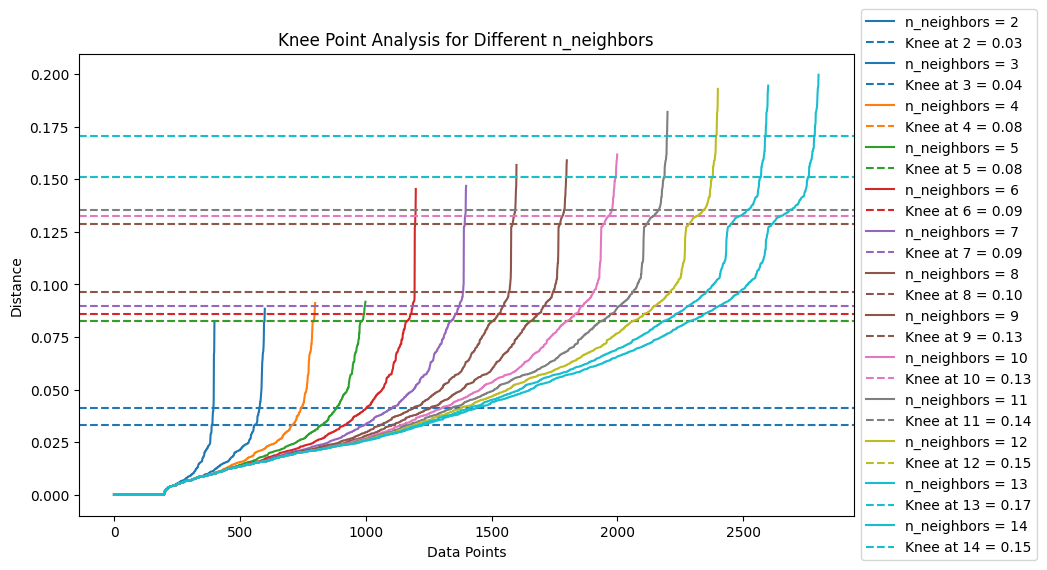

In [128]:
limite_sup = 15

n_neighbors_list_gower = np.arange(2,limite_sup,1)
epsilon_list_gower = find_knee_points(dist_mat2, n_neighbors_list_gower, metric='precomputed')

In [129]:
#Stats de las matrices
dist_stats_og=dist_mat_og.describe()
dist_stats2 = dist_mat2.describe() 

In [130]:
def plot_distance_stats(dist_mat, dist_stats):
    """
    Plots statistics (mean, standard deviation, and maximum) of a distance matrix with subplots.

    Parameters:
    dist_mat (DataFrame): The distance matrix containing pairwise distances.
    dist_stats (DataFrame): The DataFrame containing the statistics (mean, std, min, max) of the distance matrix.
    """

    # Extract statistics
    mean_vals = dist_stats.loc['mean']
    std_vals = dist_stats.loc['std']
    min_vals = dist_stats.loc['min']
    max_vals = dist_stats.loc['max']

    # Calculate minimum non-zero and overall maximum values
    min_non_zero = dist_mat[dist_mat > 0].min().min()
    overall_max = dist_mat.max().max()

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # Plot Mean
    axes[0].plot(mean_vals, marker='o', linestyle='-', color='b')
    axes[0].axhline(y=min_non_zero, color='r', linestyle='--', label=f'Overall Min: {min_non_zero:.4f}')
    axes[0].axhline(y=overall_max, color='g', linestyle='--', label=f'Overall Max: {overall_max:.4f}')
    axes[0].set_title('Mean of Distance Matrix')
    axes[0].set_ylabel('Mean')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Standard Deviation
    axes[1].plot(std_vals, marker='o', linestyle='-', color='g')
    axes[1].set_title('Standard Deviation of Distance Matrix')
    axes[1].set_ylabel('Standard Deviation')
    axes[1].grid(True)

    # Plot Maximum
    axes[2].plot(max_vals, marker='o', linestyle='-', color='m')
    axes[2].set_title('Maximum of Distance Matrix')
    axes[2].set_ylabel('Maximum')
    axes[2].set_xlabel('Index')
    axes[2].grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

Matriz de distancias con 8 variables : 



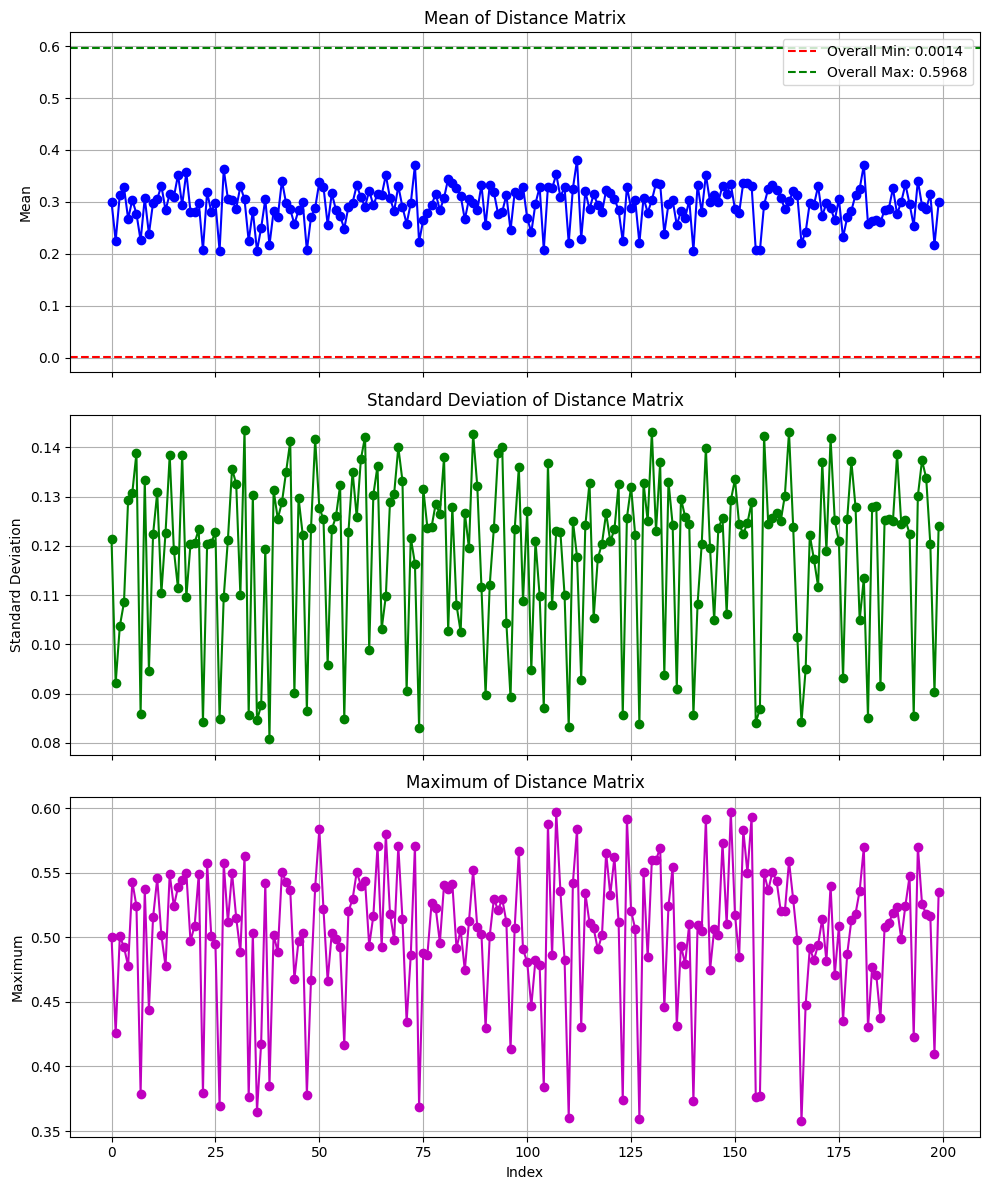

In [131]:
print("Matriz de distancias con 8 variables : \n")
plot_distance_stats(dist_mat2, dist_stats2)

Matriz de distancias con 2 variables : 



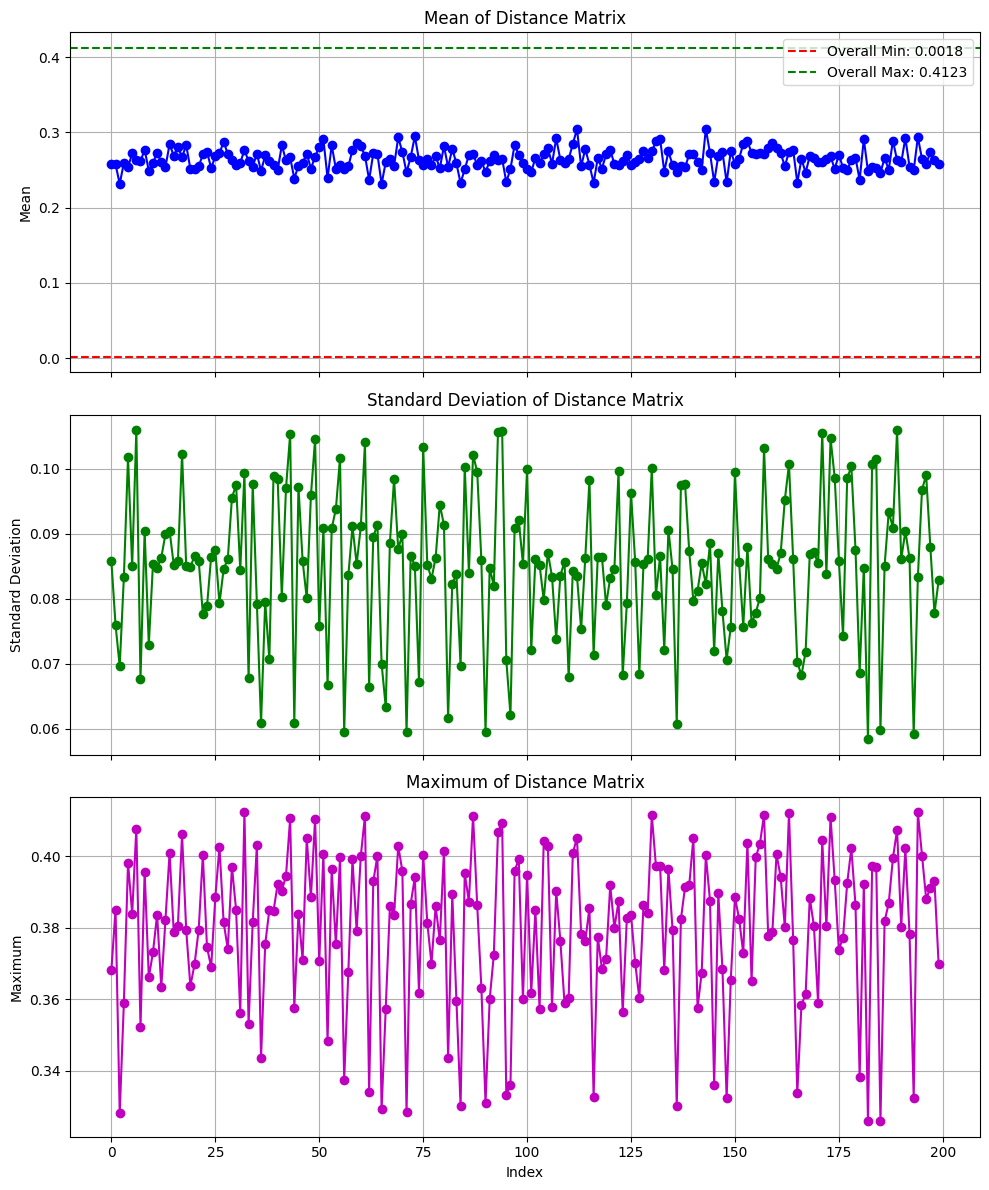

In [132]:
print("Matriz de distancias con 2 variables : \n")
plot_distance_stats(dist_mat_og, dist_stats_og)

Como se puede ver trabajar con menos variables siempre facilita las cosas, pero ahora vaoms a ver que se puede crear con todas estas variables

In [133]:
# DBSCAN across different epsilons and min_samples find # clusters > 1
def find_clusters_across_epsilons(data, epsilon_list, min_samples_list, metric='euclidean'):
    # Initialize a list to store DataFrames with clustering results
    resultados = []
    
    for i, e in enumerate(epsilon_list):        
        for j, n in enumerate(min_samples_list):
            # Apply DBSCAN with the current epsilon and min_samples
            db = DBSCAN(eps=e, min_samples=n, metric=metric).fit(data)
            cluster_labels = db.labels_
            n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            
            if n_clusters > 1:
                # Create a DataFrame with the data and the assigned clusters
                resultado = pd.DataFrame(data).assign(Cluster=cluster_labels)
                # Store the DataFrame in the list along with the current parameters
                resultados.append((e, n, resultado))
    
    return resultados

In [134]:
cluster_results = find_clusters_across_epsilons(dist_mat2, epsilon_list_gower, min_samples_list, metric = 'precomputed')

# Example: Accessing the results
for eps, min_samples, df in cluster_results:
    print(f"Epsilon: {eps}, Min Samples: {min_samples}")
    print(df.head(1)) 

Epsilon: 0.033402904868125916, Min Samples: 2
     0         1         2         3         4         5         6         7  \
0  0.0  0.233512  0.308612  0.439862  0.322762  0.491503  0.315752  0.327294   

          8         9  ...       191       192       193       194       195  \
0  0.416219  0.251785  ...  0.193239  0.076243  0.318708  0.487148  0.370805   

        196       197       198       199  Cluster  
0  0.312227  0.204055  0.217619  0.057476        0  

[1 rows x 201 columns]
Epsilon: 0.033402904868125916, Min Samples: 4
     0         1         2         3         4         5         6         7  \
0  0.0  0.233512  0.308612  0.439862  0.322762  0.491503  0.315752  0.327294   

          8         9  ...       191       192       193       194       195  \
0  0.416219  0.251785  ...  0.193239  0.076243  0.318708  0.487148  0.370805   

        196       197       198       199  Cluster  
0  0.312227  0.204055  0.217619  0.057476        0  

[1 rows x 201 columns]
Epsi

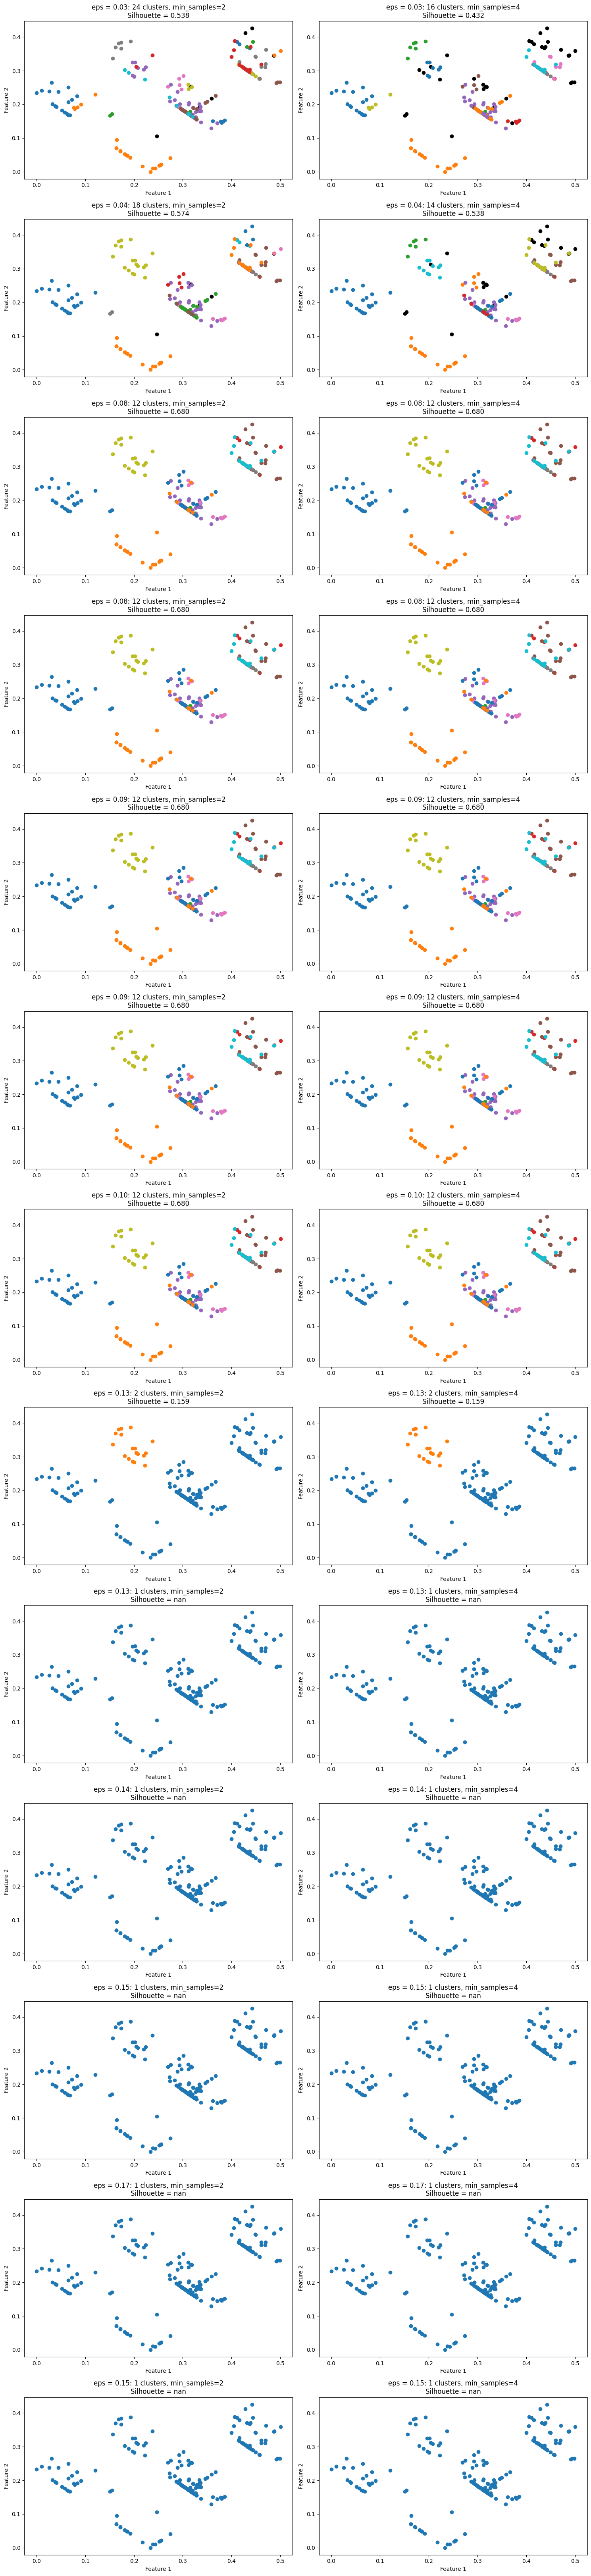

In [135]:
plot_dbscan_across_epsilons(dist_mat2, epsilon_list_gower, min_samples_list, metric = 'precomputed')

#### Se escoge entonces en este segundo caso `eps` 0.08 y `min_samples` 3 con un Silhoutte de 0.680 lo que resulta en 12 clusters



Valor del score de silhouette para DBSCAN: 0.639


Cluster                       -1              0             1             2   \
Ingreso       count      3.000000      22.000000     18.000000      5.000000   
              mean   20279.960000   71073.037273  43869.874444  51517.958000   
              std     2150.236420   29563.397008  19403.631196   9902.628197   
              min    18284.380000   19281.750000  15766.840000  37926.150000   
              25%    19141.385000   51997.102500  28675.170000  46970.540000   
              50%    19998.390000   74700.705000  46426.885000  50529.760000   
              75%    21277.750000   94355.725000  61927.732500  59872.080000   
              max    22557.110000  119534.680000  71427.640000  62291.260000   
Puntaje_Gasto count      3.000000      22.000000     18.000000      5.000000   
              mean      67.666667      43.863636     62.944444     48.000000   
              std       53.407240      25.848083     17.899958      7.713624   
              min        6.000000       6.000000     29.000000     35.000000   
              25%       52.000000      26.250000     50.500000     48.000000   
              50%       98.000000      39.500000     61.000000     50.000000   
              75%       98.500000      68.500000     76.750000     52.000000   
              max       99.000000      91.000000     94.000000     55.000000   

Cluster                        3              4              5             6   \
Ingreso       count      9.000000      32.000000      22.000000     16.000000   
              mean   55780.227778   65815.380000   78927.434545  46748.482500   
              std    25094.510046   23049.652497   32734.446993  21515.089905   
              min    18434.740000   19003.520000   22531.850000  13458.020000   
              25%    42262.040000   46428.232500   61793.415000  29984.652500   
              50%    54475.760000   72515.755000   77390.985000  47652.490000   
              75%    71651.080000   78621.062500   96065.522500  60447.452500   
              max    94049.490000  103654.790000  138584.520000  80360.650000   
Puntaje_Gasto count      9.000000      32.000000      22.000000     16.000000   
              mean      28.444444      63.656250      62.454545     51.875000   
              std       23.173860      21.413908      28.468407     27.796583   
              min        3.000000      22.000000       1.000000      5.000000   
              25%       11.000000      45.750000      55.250000     40.500000   
              50%       15.000000      70.000000      71.000000     53.500000   
              75%       51.000000      83.750000      80.250000     69.250000   
              max       60.000000      95.000000      97.000000     92.000000   

Cluster                        7             8             9              10  \
Ingreso       count      9.000000     18.000000     14.000000      25.000000   
              mean   51366.806667  67001.986111  58029.127143   59210.614800   
              std    14577.260971  22499.533107  20522.769162   26541.550152   
              min    18437.210000  18797.160000  24993.780000   24402.320000   
              25%    45222.060000  58063.710000  43724.237500   41739.840000   
              50%    52200.840000  71638.860000  60761.560000   54827.740000   
              75%    61969.150000  83590.710000  69593.585000   67219.480000   
              max    64156.370000  91426.180000  97525.800000  126685.780000   
Puntaje_Gasto count      9.000000     18.000000     14.000000      25.000000   
              mean      46.000000     50.777778     34.357143      37.280000   
              std       13.453624     33.502512     15.775381      16.754402   
              min       14.000000      1.000000      4.000000       5.000000   
              25%       43.000000     17.750000     26.750000      24.000000   
              50%       48.000000     51.500000     38.500000      43.000000   
              75%       55.000000     84.750000     46.000000

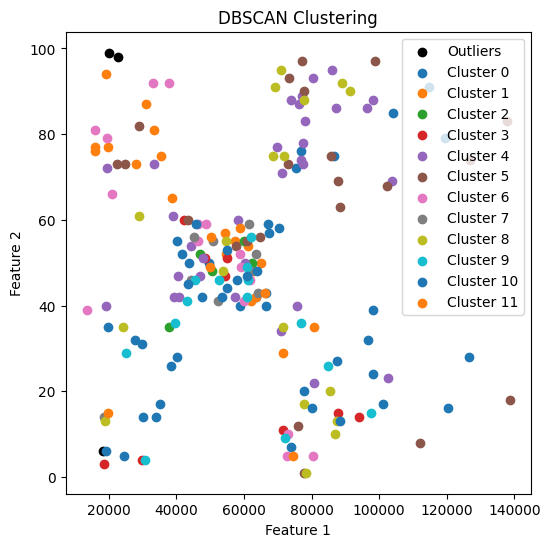

In [136]:
X = dist_mat2

# Calculo de los grupos con las mejores configuraciones
db = DBSCAN(eps=0.08, min_samples=4, metric="precomputed").fit(X)
clusteres = db.labels_
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
resultado = pd.DataFrame(X_cat).assign(Cluster=clusteres)

# Cálculo de Silhouette Score, solo si hay más de un cluster
if n_clusteres > 1:
    silhouette_dbscan_gower = silhouette_score(X, clusteres, metric="precomputed")
    print(f"Valor del score de silhouette para DBSCAN: {silhouette_dbscan_gower:.3f}")
else:
    silhouette_dbscan_gower = np.nan
    print("No se puede calcular el score de silhouette con menos de 2 clusters.")

# Creación del gráfico
fig, ax = plt.subplots(figsize=(6, 6))

for k in np.unique(clusteres):
    if k != -1:
        ax.scatter(
            x=resultado.loc[resultado.Cluster == k, resultado.columns[0]], 
            y=resultado.loc[resultado.Cluster == k, resultado.columns[1]],
            label=f'Cluster {k}'
        )
    else:
        ax.scatter(
            x=resultado.loc[resultado.Cluster == k, resultado.columns[0]], 
            y=resultado.loc[resultado.Cluster == k, resultado.columns[1]],
            c="black",
            label='Outliers'
        )

ax.legend()
ax.set_title('DBSCAN Clustering')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

# Valores Descriptivos
df_resultado_gower = pd.concat([X_cat, resultado["Cluster"]], axis=1)
display(df_resultado_gower.groupby("Cluster")[["Ingreso", "Puntaje_Gasto"]].describe().T)

plt.show()

In [58]:
df_datos_scaled_categ=df_datos[["Ingreso","Puntaje_Gasto","Genero","rango_edades",]]
df_datos_scaled_categ.head()

Ingreso  Puntaje_Gasto  Genero rango_edades
0  98115.05             39   Mujer     3. 35-44
1  35458.14             75   Mujer     1. 18-24
2  59872.08             55   Mujer       6. 65+
3  48508.93             51  Hombre     5. 55-64
4  44431.11             54   Mujer     2. 25-34

Al ser 12 clusters cambiaria la estrategia de marketing, sin embargo dependiendo de la estrategia y de los recursos de la tienda **preferiria utilizar el clustering agglomerativo** ya que este asigna a todas las observaciones a un cluster mas facil de entender lo que en ciertas ocaciones puede ser mejor que dejar observaciones sin grupo (outliers).


Si bien la estrategia es la misma a la sugerida en puntos anteriores las nuevas dimensiones (Genero y Edad) abren la posibilidad de personalizar las comunicaciones, canales (por donde llegaran las ofertas) y las caracteristicas de los productos que se van a promocionar en cada uno, por ejemplo el canal por el que llega una oferta sera distinto para las personas jovenes que para las personas viejas; Asi mismo un producto ofertado para mujeres con altos ingresos sera distinto a uno para hombres con bajos ingresos.



Para los outliers se puede plantear asignarlos a un cluster con otra estrategia como **agglomerative clustering** o asignar una comunicacion generica para estos.

## Opcion 2 sin usar dummys

A continuacion otra forma de hacerlo con una eleccion diferente de eps y min samples

In [59]:
distancias_gower = gower.gower_matrix(df_datos_scaled_categ)
pd.DataFrame(distancias_gower)

0         1         2         3         4         5         6    \
0    0.000000  0.467024  0.367225  0.629724  0.395525  0.733005  0.381504   
1    0.467024  0.000000  0.349799  0.587300  0.321499  0.526185  0.335520   
2    0.367225  0.349799  0.000000  0.532907  0.283402  0.615780  0.332659   
3    0.629724  0.587300  0.532907  0.000000  0.515800  0.353281  0.615567   
4    0.395525  0.321499  0.283402  0.515800  0.000000  0.337481  0.116061   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.491610  0.289892  0.374385  0.611886  0.096085  0.263707  0.120310   
196  0.374453  0.342571  0.308248  0.525341  0.274847  0.608552  0.390908   
197  0.408111  0.624760  0.622518  0.339611  0.589117  0.348575  0.705178   
198  0.435238  0.031786  0.318013  0.555514  0.289713  0.547767  0.349652   
199  0.114951  0.352072  0.354314  0.637222  0.387716  0.628258  0.271655   

          7         8         9    ...       190       191       192  \
0    0.654588  0.582437  0.503569  ...  0.299865  0.386479  0.152487   
1    0.312435  0.651502  0.036545  ...  0.516888  0.774423  0.380864   
2    0.537363  0.618029  0.386344  ...  0.417090  0.674624  0.366894   
3    0.274864  0.400937  0.623845  ...  0.679589  0.437123  0.583987   
4    0.516446  0.401431  0.358044  ...  0.195389  0.702924  0.333493   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.587022  0.426088  0.263551  ...  0.291475  0.799009  0.405450   
196  0.541293  0.676278  0.379116  ...  0.424318  0.681852  0.308646   
197  0.355563  0.490548  0.615867  ...  0.687567  0.195101  0.301542   
198  0.280649  0.635022  0.068331  ...  0.485102  0.742637  0.349902   
199  0.621270  0.549429  0.388618  ...  0.414816  0.455201  0.221209   

          193       194       195       196       197       198       199  
0    0.637416  0.724295  0.491610  0.374453  0.408111  0.435238  0.114951  
1    0.503077  0.690945  0.289892  0.342571  0.624760  0.031786  0.352072  
2    0.653278  0.688703  0.374385  0.308248  0.622518  0.318013  0.354314  
3    0.415777  0.405795  0.611886  0.525341  0.339611  0.555514  0.637222  
4    0.681578  0.655301  0.096085  0.274847  0.589117  0.289713  0.387716  
..        ...       ...       ...       ...       ...       ...       ...  
195  0.777663  0.695886  0.000000  0.367157  0.603908  0.306372  0.391965  
196  0.660506  0.380454  0.367157  0.000000  0.564270  0.310785  0.412563  
197  0.423755  0.341979  0.603908  0.564270  0.000000  0.605526  0.476833  
198  0.471291  0.671710  0.306372  0.310785  0.605526  0.000000  0.371307  
199  0.706138  0.793017  0.391965  0.412563  0.476833  0.371307  0.000000  

[200 rows x 200 columns]

In [60]:
def itera_clusters(df_info, iteraciones, metrica="euclidean",df_distancias=None):
    '''
    funcion que muestra los clusters formados por la combinacion de distintos parametros de eps y min_samples en la funcion DBSCAN,
    adicionalmente calcula el score de Silhouette para los cluster formados

    parametros:
    df_info: dataset con los datos cuantitativos originales en dos dimensiones
    iteraciones: array con la combinacion de parametros de eps y min_samples a probar
    metrica: metrica a aplicar en los algoritmos de DBSCAN y calculo de Solhouette
    df_distancias: dataframe con las distancias entre todos los puntos
    
    '''
    # incializacion del arreglo de salida
    arr_silhouettes = []

    # funcion que asigna como variable X las distancias entre puntos cuando la metrica es precomputed, de lo contrario X sera los datos de entrada
    if metrica == "precomputed":
        X = df_distancias
    else:
        X = df_info
    
    # parametros para las graficas
    n_cols = 5
    n_rows = int(np.ceil(len(iteraciones)/n_cols))

    fig, ax = plt.subplots(n_rows, n_cols,figsize=(n_cols*6,n_rows*6))
    axs = ax.flatten()

    # iteracion sobre los parametros 
    for i,(eps,min_samples) in enumerate(iteraciones):
        
        # Ejecucion del algoritmo DBSCAN
        db = DBSCAN(eps = eps, min_samples = min_samples, metric=metrica).fit(X)
        # Extraccion de los label de los cluster
        clusteres = db.labels_
        # Calculo de la cantidad de clusteres encontrados por DBSCAN
        n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
        
        # Genera un dataframe resultado con los datos "originales" mas una columna con los labels de los cluster encontrados
        resultado = pd.DataFrame(df_info).assign(Cluster = clusteres)
        
        # calculo del score de silhouette
        silhouette = silhouette_score(X, clusteres, metric=metrica)
        arr_silhouettes.append(silhouette)

        
        # Grafica de cada grupo encontrado por DBSCAN
        for k in np.unique(clusteres):
            if k != -1:
                axs[i].scatter(
                    x = resultado.loc[resultado.Cluster == k, 0], 
                    y = resultado.loc[resultado.Cluster == k, 1]
                    )
            else:
                axs[i].scatter(
                    x = resultado.loc[resultado.Cluster == k, 0], 
                    y = resultado.loc[resultado.Cluster == k, 1],
                    c = "black"
                    )
                
        axs[i].set_title("param: eps:{e:.4f} ,min_samples:{s}, neighbors:{n}".format(e=np.round(eps,2),s=min_samples,n=n_clusteres))
                
    # Remover axis de graficas no utilizadas
    for j in range(i + 1, n_rows * n_cols):
        axs[j].axis('off')


    return arr_silhouettes

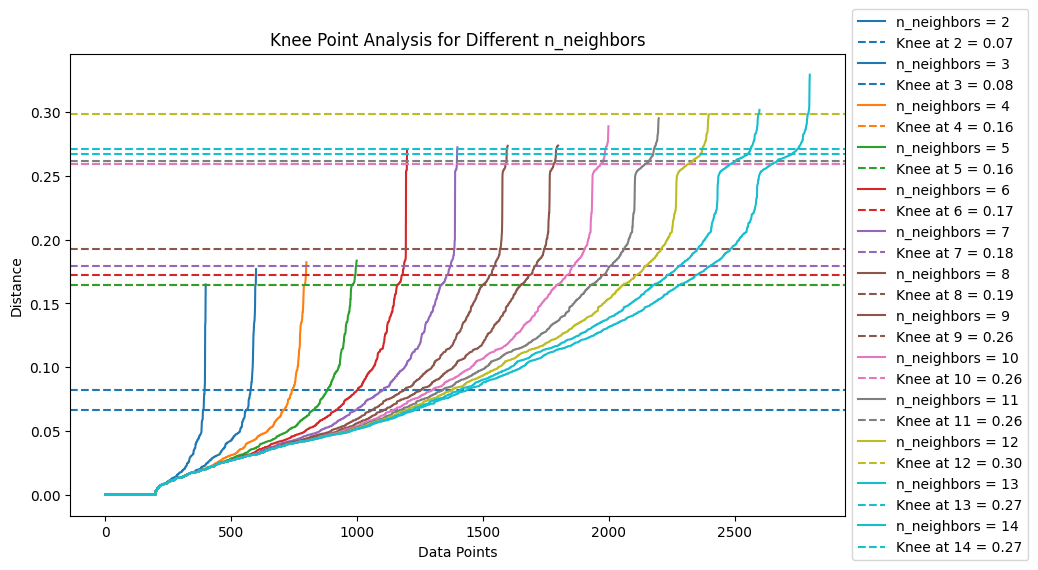

In [61]:
n_neighbors_list_gower = np.arange(2,limite_sup,1)
epsilon_list_gower = find_knee_points(distancias_gower, n_neighbors_list_gower, metric='precomputed')

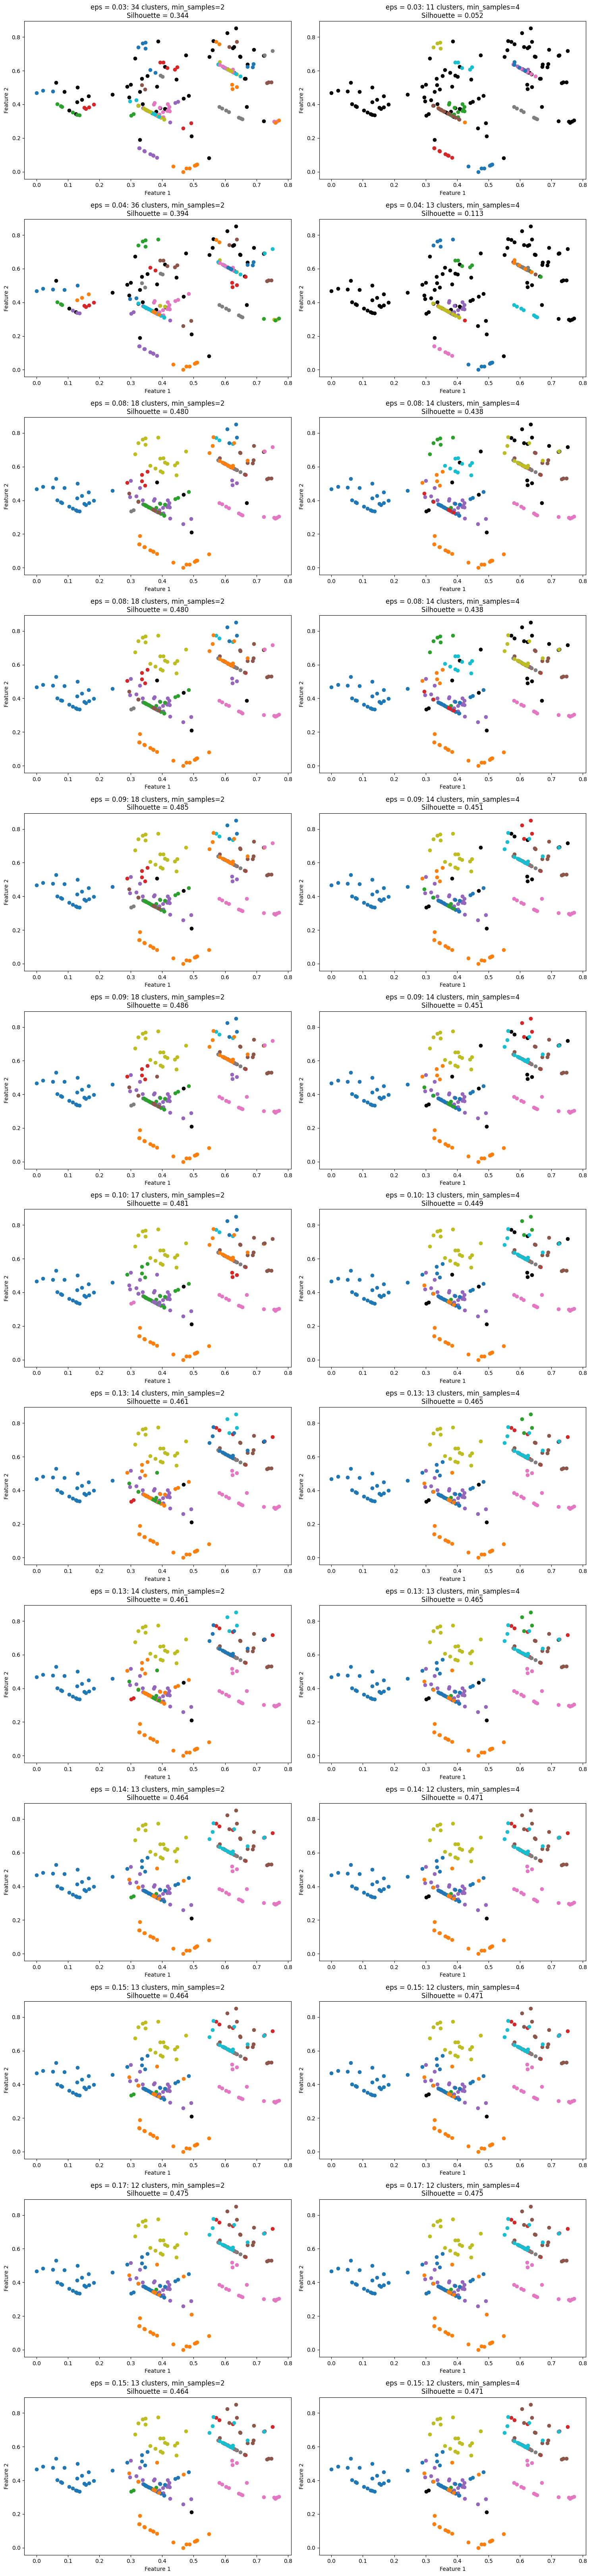

In [91]:
plot_dbscan_across_epsilons(distancias_gower, epsilon_list_gower, min_samples_list, metric = 'precomputed')

Como ya hemos visto los graficos anteriores ilustran los grupos formados para los distintos pares de parametros probados, en este caso al incorporar mas de 2 dimensiones la visualizacion se dificulta y esto logra que se vean grupos "menos" uniformes pero esto es debido a que no estamos viendo las otras 2 dimensiones utilizadas. 



#### Se escoge entonces en este segundo caso `eps` 0.09 y `min_samples` 2 con un Silhoutte de 0.486 lo que resulta en 18 clusters


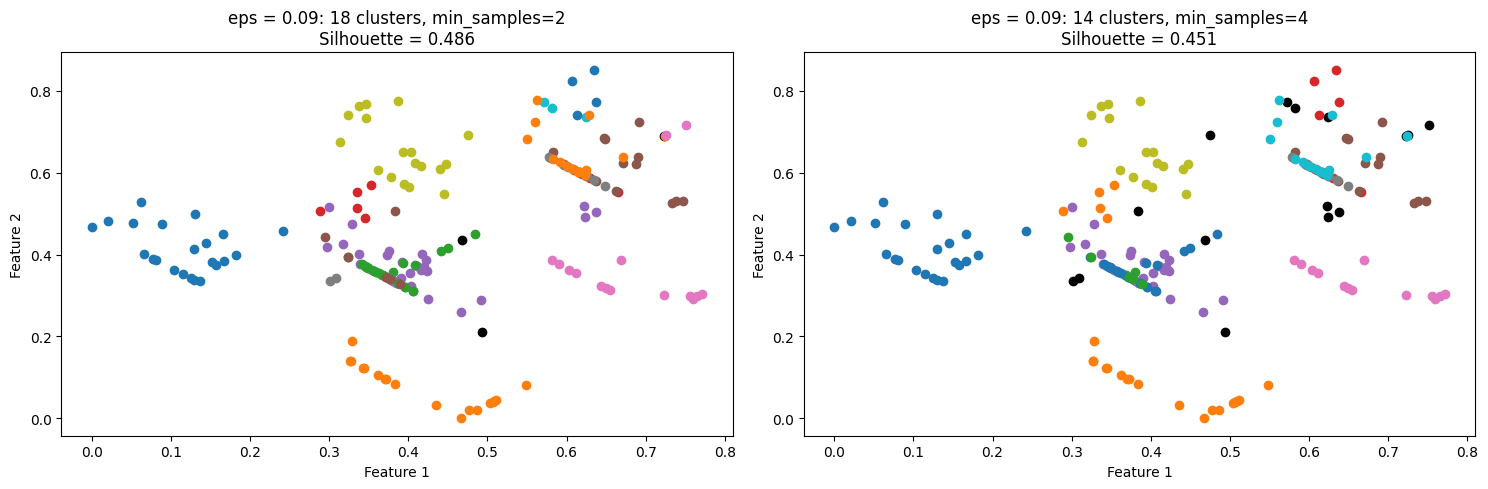

In [96]:
epsilon_elegido=[0.09]
min_sample_elegido=[2,4]
plot_dbscan_across_epsilons(distancias_gower, epsilon_elegido, min_sample_elegido, metric = 'precomputed')

Valor del score de silhouette para DBSCAN: 0.583


Cluster                       -1              0             1             2   \
Ingreso       count      3.000000      22.000000     18.000000      5.000000   
              mean   18779.753333   71073.037273  43869.874444  51517.958000   
              std      729.669451   29563.397008  19403.631196   9902.628197   
              min    18284.380000   19281.750000  15766.840000  37926.150000   
              25%    18360.795000   51997.102500  28675.170000  46970.540000   
              50%    18437.210000   74700.705000  46426.885000  50529.760000   
              75%    19027.440000   94355.725000  61927.732500  59872.080000   
              max    19617.670000  119534.680000  71427.640000  62291.260000   
Puntaje_Gasto count      3.000000      22.000000     18.000000      5.000000   
              mean      11.666667      43.863636     62.944444     48.000000   
              std        4.932883      25.848083     17.899958      7.713624   
              min        6.000000       6.000000     29.000000     35.000000   
              25%       10.000000      26.250000     50.500000     48.000000   
              50%       14.000000      39.500000     61.000000     50.000000   
              75%       14.500000      68.500000     76.750000     52.000000   
              max       15.000000      91.000000     94.000000     55.000000   

Cluster                        3              4              5             6   \
Ingreso       count      4.000000      32.000000      18.000000     13.000000   
              mean   50051.832500   65815.380000   74008.443333  40133.600769   
              std     5964.577331   23049.652497   31999.733071  17965.010783   
              min    42262.040000   19003.520000   22531.850000  13458.020000   
              25%    46947.207500   46428.232500   58380.715000  20989.640000   
              50%    51492.345000   72515.755000   75213.745000  46278.660000   
              75%    54596.970000   78621.062500   88242.815000  58724.710000   
              max    54960.600000  103654.790000  137838.570000  61886.710000   
Puntaje_Gasto count      4.000000      32.000000      18.000000     13.000000   
              mean      52.250000      63.656250      74.166667     62.307692   
              std        5.500000      21.413908      13.904083     18.318409   
              min       47.000000      22.000000      54.000000     39.000000   
              25%       50.000000      45.750000      64.250000     49.000000   
              50%       51.000000      70.000000      73.000000     59.000000   
              75%       53.250000      83.750000      82.750000     79.000000   
              max       60.000000      95.000000      97.000000     92.000000   

Cluster                        7             8             9              10  \
Ingreso       count      8.000000     18.000000      3.000000       4.000000   
              mean   55483.006250  67001.986111  84479.060000  101062.895000   
              std     8281.383344  22499.533107  11549.065617   29995.910030   
              min    44346.140000  18797.160000  71651.080000   75943.710000   
              25%    49474.852500  58063.710000  79693.845000   77321.580000   
              50%    56863.630000  71638.860000  87736.610000   94861.675000   
              75%    62364.517500  83590.710000  90893.050000  118602.990000   
              max    64156.370000  91426.180000  94049.490000  138584.520000   
Puntaje_Gasto count      8.000000     18.000000      3.000000       4.000000   
              mean      50.000000     50.777778     13.333333       9.750000   
              std        6.502747     33.502512      2.081666       7.135592   
              min       41.000000      1.000000     11.000000       1.000000   
              25%       45.250000     17.750000     12.500000       6.250000   
              50%       50.000000     51.500000     14.000000      10.000000   
              75%       55.250000     84.750000     14.500000

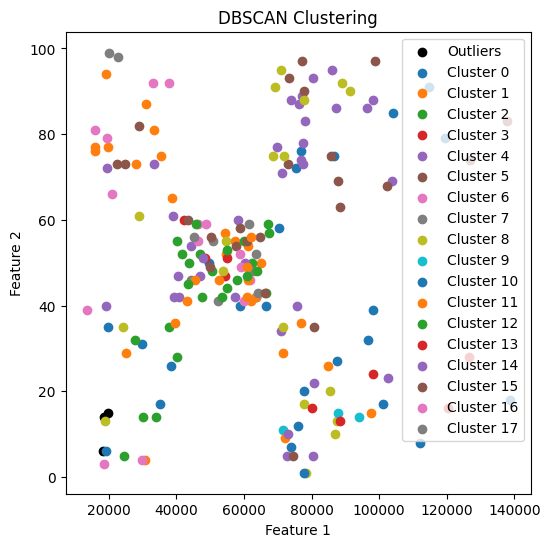

In [103]:
X = distancias_gower

# Calculo de los grupos con las mejores configuraciones
db = DBSCAN(eps=0.09, min_samples=2, metric="precomputed").fit(X)
clusteres = db.labels_
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
resultado = pd.DataFrame(df_datos_scaled_categ).assign(Cluster=clusteres)

# Cálculo de Silhouette Score, solo si hay más de un cluster
if n_clusteres > 1:
    silhouette_dbscan_gower = silhouette_score(X, clusteres, metric="precomputed")
    print(f"Valor del score de silhouette para DBSCAN: {silhouette_dbscan_gower:.3f}")
else:
    silhouette_dbscan_gower = np.nan
    print("No se puede calcular el score de silhouette con menos de 2 clusters.")

# Creación del gráfico
fig, ax = plt.subplots(figsize=(6, 6))

for k in np.unique(clusteres):
    if k != -1:
        ax.scatter(
            x=resultado.loc[resultado.Cluster == k, resultado.columns[0]], 
            y=resultado.loc[resultado.Cluster == k, resultado.columns[1]],
            label=f'Cluster {k}'
        )
    else:
        ax.scatter(
            x=resultado.loc[resultado.Cluster == k, resultado.columns[0]], 
            y=resultado.loc[resultado.Cluster == k, resultado.columns[1]],
            c="black",
            label='Outliers'
        )

ax.legend()
ax.set_title('DBSCAN Clustering')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

# Valores Descriptivos
df_resultado_gower = pd.concat([df_datos_scaled_categ, resultado["Cluster"]], axis=1)
display(df_resultado_gower.groupby("Cluster")[["Ingreso", "Puntaje_Gasto"]].describe().T)

plt.show()

Ingreso  Puntaje_Gasto  Hombre  Mujer  1. 18-24  2. 25-34  \
Cluster                                                                    
-1        18779.753333      11.666667    33.3   66.7      33.3       0.0   
 0        71073.037273      43.863636     0.0  100.0       0.0       0.0   
 1        43869.874444      62.944444     0.0  100.0     100.0       0.0   
 2        51517.958000      48.000000     0.0  100.0       0.0       0.0   
 3        50051.832500      52.250000   100.0    0.0       0.0       0.0   
 4        65815.380000      63.656250     0.0  100.0       0.0     100.0   
 5        74008.443333      74.166667   100.0    0.0       0.0     100.0   
 6        40133.600769      62.307692   100.0    0.0     100.0       0.0   
 7        55483.006250      50.000000   100.0    0.0       0.0       0.0   
 8        67001.986111      50.777778   100.0    0.0       0.0       0.0   
 9        84479.060000      13.333333   100.0    0.0       0.0       0.0   
 10      101062.895000       9.750000   100.0    0.0       0.0     100.0   
 11       58029.127143      34.357143   100.0    0.0       0.0       0.0   
 12       48313.954500      41.750000     0.0  100.0       0.0       0.0   
 13      102797.256000      19.400000     0.0  100.0       0.0       0.0   
 14       75412.970000       6.666667   100.0    0.0     100.0       0.0   
 15       63345.628333      41.000000     0.0  100.0       0.0       0.0   
 16       24188.770000       3.500000   100.0    0.0       0.0       0.0   
 17       21277.750000      98.500000     0.0  100.0       0.0       0.0   

         3. 35-44  4. 45-54  5. 55-64  6. 65+  
Cluster                                        
-1            0.0       0.0      33.3    33.3  
 0          100.0       0.0       0.0     0.0  
 1            0.0       0.0       0.0     0.0  
 2            0.0       0.0       0.0   100.0  
 3            0.0       0.0     100.0     0.0  
 4            0.0       0.0       0.0     0.0  
 5            0.0       0.0       0.0     0.0  
 6            0.0       0.0       0.0     0.0  
 7            0.0       0.0       0.0   100.0  
 8          100.0       0.0       0.0     0.0  
 9            0.0       0.0     100.0     0.0  
 10           0.0       0.0       0.0     0.0  
 11           0.0     100.0       0.0     0.0  
 12           0.0     100.0       0.0     0.0  
 13           0.0     100.0       0.0     0.0  
 14           0.0       0.0       0.0     0.0  
 15           0.0       0.0     100.0     0.0  
 16           0.0       0.0     100.0     0.0  
 17         100.0       0.0       0.0     0.0

Text(0.5, 1.0, 'Ayuda visual para entender las variables categoricas en la composicion de clusteres')

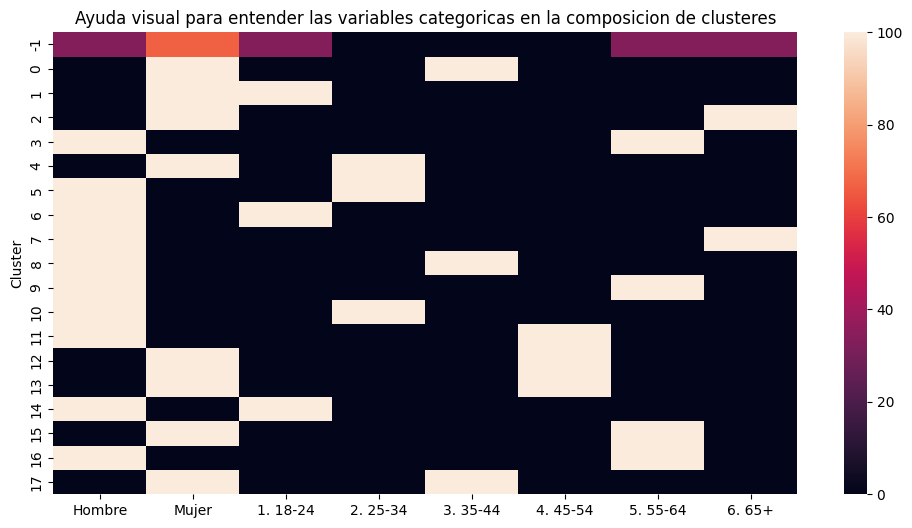

In [104]:
# Generar grupo por Genero
gender_counts = df_resultado_gower.groupby('Cluster')['Genero'].value_counts().unstack(fill_value=0)

# Calculo del total por cada cluster
gender_counts['Total'] = gender_counts.sum(axis=1)

# Calculo del porcentaje de cada categoria por cluster
gender_counts['Hombre'] = np.round((gender_counts['Hombre'] / gender_counts['Total']) * 100,1)
gender_counts['Mujer'] = np.round((gender_counts['Mujer'] / gender_counts['Total']) * 100,1)


# Generar grupo por rango de edad
age_range_counts = df_resultado_gower.groupby('Cluster')['rango_edades'].value_counts().unstack(fill_value=0)

# Calculo del total por cada cluster 
age_range_counts['Total'] = age_range_counts.sum(axis=1)

# Calculo de porcentaje de cada categoria por cluster
age_range_counts["1. 18-24"] = np.round(100* age_range_counts["1. 18-24"]/age_range_counts["Total"] , 1)
age_range_counts["2. 25-34"] = np.round(100* age_range_counts["2. 25-34"]/age_range_counts["Total"] , 1)
age_range_counts["3. 35-44"] = np.round(100* age_range_counts["3. 35-44"]/age_range_counts["Total"] , 1)
age_range_counts["4. 45-54"] = np.round(100* age_range_counts["4. 45-54"]/age_range_counts["Total"] , 1)
age_range_counts["5. 55-64"] = np.round(100* age_range_counts["5. 55-64"]/age_range_counts["Total"] , 1)
age_range_counts["6. 65+"] = np.round(100* age_range_counts["6. 65+"]/age_range_counts["Total"] , 1)


# Calculo de variables cuantitativas
categoricas_desc = df_resultado_gower.groupby("Cluster").agg({"Ingreso":"mean","Puntaje_Gasto":"mean"})


# Combinar los 3 reportes para obtener una unica visual
combined_stats = pd.concat([categoricas_desc,gender_counts.drop(columns="Total"), age_range_counts.drop(columns="Total")], axis=1)

display(combined_stats)

# Heatmap para ayudar visualmente a entender la composicion de los cluster

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(combined_stats.iloc[:,2:], ax=ax)
ax.set_title("Ayuda visual para entender las variables categoricas en la composicion de clusteres")

Al ver el resultado del agrupamiento con variables categoricas, vemos que ahora se identifican clusters definidos a partir de estas, a comparacion de los clusters anteriores se ha perdido en cierta manera la division natural que existia con ingresos y puntaje de Gasto, estas ultimas variables cuantitativas ya no son evidentes, pues se tiene una division ademas de estos dos variables la infromacion del cliente que agrega otro grado de complejidad


Al ser 18 clusters cambiaria la estrategia de marketing, sin embargo dependiendo de la estrategia y de los recursos de la tienda **preferiria utilizar el clustering agglomerativo** ya que este asigna a todas las observaciones a un cluster mas facil de entender lo que en ciertas ocaciones puede ser mejor que dejar observaciones sin grupo (outliers).


Si bien la estrategia es la misma a la sugerida en puntos anteriores las nuevas dimensiones (Genero y Edad) abren la posibilidad de personalizar las comunicaciones, canales (por donde llegaran las ofertas) y las caracteristicas de los productos que se van a promocionar en cada uno, por ejemplo el canal por el que llega una oferta sera distinto para las personas jovenes que para las personas viejas; Asi mismo un producto ofertado para mujeres con altos ingresos sera distinto a uno para hombres con bajos ingresos.



Para los outliers se puede plantear asignarlos a un cluster con otra estrategia como **agglomerative clustering** o asignar una comunicacion generica para estos.